In [1]:
import pandas as pd
import numpy as np
import gc
import cv2
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
from sklearn.preprocessing import LabelEncoder
from torchcontrib.optim import SWA
from torchensemble import VotingClassifier
from PIL import Image

In [2]:
train_filepath = './train/'
test_filepath = './test/'

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

train_df['filepath'] = train_filepath + train_df['image']
test_df['image_path'] = './test/' + test_df['image']

In [3]:
def prepare_label(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values).reshape(len(values), 1)
    return integer_encoded, label_encoder

target, label_encoder = prepare_label(train_df['label'])

In [4]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((300, 300)),
])

# transforms_train = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     transforms.RandomChoice([
#         transforms.RandomResizedCrop(224),
#         transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
#         transforms.RandomAffine(degrees=15, translate= (0.2, 0.2),
#                                scale = (0.8, 1.2), shear = 15,
#                                resample = Image.BILINEAR)])
#     ])

# transform_train = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomChoice([
#                 transforms.RandomResizedCrop(64),
#                 transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
#                 transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
#                                         scale=(0.8, 1.2), shear=15,
#                                         resample=Image.BILINEAR)]),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                             std=[0.229, 0.224, 0.225])    
#     ])

In [5]:
from PIL import Image
class Img_Dataset(Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img = self.transform(img)
        
        return img

In [6]:
trainset = torchvision.datasets.ImageFolder('./train/', transform = transformer)
# validset = torchvision.datasets.ImageFolder('./seg_test/', transform=transformer)
testset = Img_Dataset(test_df['image_path'].values.tolist(), transform = transformer)
trainloader = DataLoader(trainset, batch_size = 15, shuffle = True)
testloader = DataLoader(testset, batch_size = 15)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import gc
gc.collect()

0

In [8]:
# Ensemble 적용
# 연속해서 계속 더하는 방식으로 진행해야 함
ensemble_array = []
for i in range(4):
    print(f'{i+1} Model')
    model = EfficientNet.from_pretrained('efficientnet-b3')
    model._fc = nn.Linear(model._fc.in_features, 6)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
    opt = SWA(optimizer)
    
    gc.collect()
    
    for ep in range(1, 60):
        running_loss = 0.0
        for data in trainloader:
            image, labels = data[0].to(device), data[1].to(device)
            outputs = model(image)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()
            running_loss += loss.item()
        lr_sched.step()
        print('Epoch : [%d] loss : %.3f' % (ep, running_loss / len(trainloader)))
    
    opt.swap_swa_sgd()
    opt.swap_swa_sgd()
    
    predicted = []
    with torch.no_grad():
        model.eval()
        for data in testloader:
            outputs = model(data.to(device))
            predicted += outputs.cpu()
    
    ensemble_array.append(predicted)
    
    pred = torch.zeros(2999, 6)
    for ensem in ensemble_array:
        for jp, en in enumerate(ensem):
            pred[jp] += en
    
    pred = pred / len(ensemble_array)
    _, predict = torch.max(pred, 1)
    
    array = label_encoder.inverse_transform(predict)
    array.reshape(len(array) , 1)
    
    submission = pd.DataFrame({
        "image" : test_df['image'],
        "label" : array
    })
    
    submission.to_csv(f'efff_count{i+1}.csv', index = False)

1 Model
Loaded pretrained weights for efficientnet-b3
Epoch : [1] loss : 0.403
Epoch : [2] loss : 0.279
Epoch : [3] loss : 0.236
Epoch : [4] loss : 0.200
Epoch : [5] loss : 0.173
Epoch : [6] loss : 0.142
Epoch : [7] loss : 0.122
Epoch : [8] loss : 0.107
Epoch : [9] loss : 0.088
Epoch : [10] loss : 0.083
Epoch : [11] loss : 0.073
Epoch : [12] loss : 0.068
Epoch : [13] loss : 0.065
Epoch : [14] loss : 0.059
Epoch : [15] loss : 0.056
Epoch : [16] loss : 0.054
Epoch : [17] loss : 0.052
Epoch : [18] loss : 0.050
Epoch : [19] loss : 0.047
Epoch : [20] loss : 0.040
Epoch : [21] loss : 0.045
Epoch : [22] loss : 0.038
Epoch : [23] loss : 0.043
Epoch : [24] loss : 0.039
Epoch : [25] loss : 0.037
Epoch : [26] loss : 0.036
Epoch : [27] loss : 0.035
Epoch : [28] loss : 0.034
Epoch : [29] loss : 0.032
Epoch : [30] loss : 0.032
Epoch : [31] loss : 0.030
Epoch : [32] loss : 0.033
Epoch : [33] loss : 0.028
Epoch : [34] loss : 0.029
Epoch : [35] loss : 0.027
Epoch : [36] loss : 0.028
Epoch : [37] loss :

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 5.5228e-01, -6.7893e-01, -1.2036e-01],
          [ 7.0604e-01, -7.4363e-01, -2.6014e-01],
          [-6.7103e-02, -2.3337e-01, -4.9352e-02]],

         [[ 1.6774e+00, -1.5389e+00,  2.3472e-02],
          [ 1.5085e+00, -1.4821e+00, -9.3046e-02],
          [ 2.0320e-01, -5.2762e-02,  1.2994e-01]],

         [[ 3.6452e-01, -3.0450e-01,  7.1253e-02],
          [ 5.1432e-01, -4.2652e-01, -5.5994e-02],
          [ 5.0669e-02, -4.0043e-02,  1.1402e-01]]],


        [[[-3.6185e-01, -1.3588e-01,  2.5022e-02],
          [-2.6496e+00, -3.7629e-01,  1.1743e-01],
          [-4.1378e-01, -8.3885e-02,  1.2049e-01]],

         [[ 1.7006e-01,  1.2990e-02,  1.2456e-01],
          [-1.0775e+00,  1.5183e-03,  1.8688e-01],
          [ 4.5333e-02,  1.3548e-01,  1.9922e-01]],

         [[-1.8947e-02, -2.4229e-02, -1.6753e-02],
          [-5.6020e-01, -8.63

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([0.0917, 0.0256, 0.1046, 0.0629, 0.0022, 0.0136], device='cuda:0',
       requires_grad=True); skipping it
  warnings.warn(
C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-6.5421e-02]],

         [[-4.3098e-01]],

         [[ 1.0286e-01]],

         [[-5.0610e-01]],

         [[-2.6196e-01]],

         [[-1.1469e+00]]],


        [[[-1.5972e-01]],

         [[-1.2149e-01]],

         [[ 3.7992e-03]],

         [[-8.3088e-02]],

         [[-4.6915e-01]],

         [[-1.2325e-01]]],


        [[[-6.3858e-02]],

         [[-4.6280e-01]],

         [[ 1.0157e-01]],

         [[-3.6518e-01]],

         [[-8.5246e-02]],

         [[-5.0821e-01]]],


        [[[ 3.6570e-07]],

         [[-2.9717e-01]],

         [[ 1.0034e-01]],

         [

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-1.5900e-01]],

         [[ 1.9318e-02]],

         [[ 4.8359e-01]],

         [[ 9.2557e-02]],

         [[ 5.5503e-01]],

         [[-2.6351e-02]],

         [[-7.7269e-02]],

         [[ 2.6324e-01]],

         [[ 8.2846e-02]],

         [[-2.0762e-03]],

         [[-1.4410e-01]],

         [[-7.0669e-02]],

         [[ 2.1548e-01]],

         [[-2.0606e-03]],

         [[-9.3169e-02]],

         [[-2.7731e-02]],

         [[ 1.9792e-02]],

         [[-1.0919e-01]],

         [[-2.6514e-01]],

         [[-7.2078e-02]],

         [[-2.1564e-01]],

         [[ 7.0224e-02]],

         [[ 6.0173e-02]],

         [[-3.0134e-01]],

         [[ 1.3025e-01]],

         [[ 3.2501e-01]],

         [[ 9.0573e-02]],

         [[-6.7694e-02]],

         [[-6.4829e-03]],

         [[ 6.9044e-01]],

         [[-3.8724e-01]],

         [[ 1.1176e-

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.3252]],

         [[-0.0960]],

         [[ 0.1523]],

         ...,

         [[ 0.1642]],

         [[ 0.1470]],

         [[-0.0823]]],


        [[[ 0.0248]],

         [[-0.6030]],

         [[ 0.3161]],

         ...,

         [[ 0.2702]],

         [[-0.3617]],

         [[ 0.2867]]],


        [[[-0.4070]],

         [[ 0.4734]],

         [[-0.9431]],

         ...,

         [[-0.5381]],

         [[ 0.2501]],

         [[ 0.1027]]],


        ...,


        [[[-0.3997]],

         [[ 0.3612]],

         [[ 0.2582]],

         ...,

         [[-0.5719]],

         [[ 0.4680]],

         [[ 0.0066]]],


        [[[ 0.3765]],

         [[-0.1408]],

         [[-0.5886]],

         ...,

         [[-0.5152]],

         [[-0.2684]],

         [[-0.2428]]],


        [[[-0.3893]],

         [[-0.7270]],

         [[-0.0181]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([1.3838, 2.4241, 1.8817, 1.4661, 2.0566, 1.6990, 2.5068, 2.1851, 1.4263,
        1.7786, 1.8291, 0.9893, 1.8667, 1.1820, 1.8870, 1.5464, 1.7127, 1.9925,
        1.1754, 2.2616, 2.6860, 1.9746, 1.1724, 1.6364, 2.1182, 1.2977, 1.4389,
        1.5564, 1.4872, 2.0522, 2.1351, 2.0372, 1.0278, 1.5306, 1.8249, 1.6636,
        2.3711, 1.8981, 1.4276, 1.0202, 0.9064, 1.6225, 2.0740, 1.5616, 0.7896,
        1.9024, 1.6087, 1.9551, 1.4631, 1.7830, 1.9117, 4.1744, 1.5784, 1.8112,
        3.4580, 1.5664, 1.7228, 1.8170, 1.6725, 1.5243, 1.8955, 1.4885, 1.8467,
        1.3967, 1.6165, 0.8242, 4.0481, 1.6225, 1.0216, 0.7285, 1.6986, 1.9860,
        1.5238, 1.7369, 1.8269, 3.4515, 1.9698, 2.0284, 2.2047, 1.7318, 2.3056,
        1.7366, 3.3759, 2.1187, 1.8242, 1.5864, 0.8847, 1.5838, 2.0477, 2.5322,
        0.9959, 2.7296, 2.5124, 1.5119, 1.6247, 2.0917, 2

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([ 2.4436,  0.1673,  0.7587,  1.1061,  1.7199,  3.0656,  1.5211,  1.7789,
         0.5780,  0.2505,  1.7291, -0.8216,  2.8270,  2.2352,  2.7497, -0.8049,
         1.5989,  1.4844, -0.7673,  3.4663,  3.2986,  0.5401,  1.7854,  2.8965,
         3.5109,  1.9081, -1.3125,  2.3621,  1.8165, -1.5166,  2.7944, -0.0994,
         2.8817, -0.4787, -0.0895, -0.6534,  1.9746,  4.3817,  1.4679, -0.4967,
        -1.1238,  3.1114, -0.0475, -1.8936, -1.4729,  2.4866, -0.9854,  1.5088,
         2.3529,  2.2219,  2.4386, -1.2149,  2.6863, -0.3277,  2.6856, -0.4283,
         1.1940,  1.7608, -1.3064,  3.4545, -0.1242, -0.7190, -0.7406,  3.1289,
         3.0171, -0.6933,  2.0744,  2.1745,  0.2079, -1.6282,  2.1554,  0.5200,
         3.1051,  1.5109,  2.9081,  1.7992,  2.8825,  2.5943,  2.2005,  0.4959,
        -1.1234, -0.9225, -0.7630, -1.8120, -1.1197,  3.0

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.1854]],

         [[ 0.0011]],

         [[ 0.1584]],

         ...,

         [[ 0.2004]],

         [[ 0.1441]],

         [[ 0.8617]]],


        [[[ 0.0310]],

         [[-0.3016]],

         [[ 0.2347]],

         ...,

         [[-0.6408]],

         [[ 0.1984]],

         [[ 0.8615]]],


        [[[ 0.1331]],

         [[-0.0403]],

         [[ 0.0395]],

         ...,

         [[-0.2479]],

         [[-0.0866]],

         [[-0.1341]]],


        ...,


        [[[-0.2520]],

         [[-0.5975]],

         [[-0.2312]],

         ...,

         [[-0.0273]],

         [[ 0.4613]],

         [[-0.1550]]],


        [[[-0.0066]],

         [[-0.5989]],

         [[-0.2596]],

         ...,

         [[-0.1356]],

         [[-0.1715]],

         [[-0.5214]]],


        [[[-0.3236]],

         [[ 0.2278]],

         [[ 0.3211]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 2.4797e-01]],

         [[ 2.8779e-01]],

         [[-5.1479e-02]],

         ...,

         [[ 1.6529e-02]],

         [[ 4.3614e-01]],

         [[ 6.4051e-01]]],


        [[[ 2.1231e-02]],

         [[-5.2330e-02]],

         [[ 2.0792e-01]],

         ...,

         [[ 1.9003e-01]],

         [[ 4.0722e-02]],

         [[ 3.5041e-02]]],


        [[[ 1.2771e-01]],

         [[ 6.9332e-01]],

         [[ 1.2491e-01]],

         ...,

         [[-2.8020e-01]],

         [[-1.1866e-05]],

         [[-1.8620e-01]]],


        ...,


        [[[ 7.9277e-02]],

         [[-3.5266e-02]],

         [[-3.0017e-02]],

         ...,

         [[-4.0849e-01]],

         [[ 6.0154e-01]],

         [[-8.6208e-02]]],


        [[[-4.0193e-01]],

         [[ 2.7429e-01]],

         [[-3.4224e-01]],

         ...,

         [[ 2.1989e-01]],

   

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.2270]],

         [[-0.0074]],

         [[-0.3984]],

         ...,

         [[-0.0438]],

         [[ 0.3029]],

         [[ 0.7023]]],


        [[[-0.1733]],

         [[-0.1844]],

         [[ 0.1013]],

         ...,

         [[ 0.5433]],

         [[ 0.1699]],

         [[ 0.3316]]],


        [[[ 0.0603]],

         [[-0.3563]],

         [[ 0.2703]],

         ...,

         [[ 0.7653]],

         [[-0.3398]],

         [[ 0.0644]]],


        ...,


        [[[-0.1869]],

         [[-0.3894]],

         [[ 0.3303]],

         ...,

         [[ 0.9026]],

         [[ 0.1098]],

         [[ 0.0082]]],


        [[[-0.0982]],

         [[-0.3782]],

         [[ 0.4256]],

         ...,

         [[-0.0769]],

         [[-0.2627]],

         [[-0.1812]]],


        [[[ 0.3289]],

         [[ 0.0768]],

         [[ 0.3735]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.6193]],

         [[-0.1216]],

         [[-0.2426]],

         ...,

         [[ 0.3658]],

         [[ 0.5350]],

         [[ 0.4803]]],


        [[[ 0.3807]],

         [[-0.6097]],

         [[-0.1954]],

         ...,

         [[-0.1445]],

         [[ 0.1729]],

         [[-0.0451]]],


        [[[-0.0454]],

         [[ 0.5658]],

         [[ 0.3759]],

         ...,

         [[-0.2008]],

         [[-0.4793]],

         [[-0.0714]]],


        ...,


        [[[ 0.3698]],

         [[ 0.3361]],

         [[ 0.1700]],

         ...,

         [[-0.2616]],

         [[ 0.4064]],

         [[-0.1952]]],


        [[[-0.0088]],

         [[ 0.3928]],

         [[ 0.2820]],

         ...,

         [[-0.7353]],

         [[ 0.2047]],

         [[-0.0537]]],


        [[[-0.3953]],

         [[-0.2206]],

         [[ 0.2959]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.2010]],

         [[ 0.3707]],

         [[-0.5837]],

         ...,

         [[-0.3856]],

         [[-0.3603]],

         [[-0.1812]]],


        [[[-0.0757]],

         [[-0.2031]],

         [[ 0.1473]],

         ...,

         [[ 0.0655]],

         [[ 0.2849]],

         [[-0.1340]]],


        [[[-0.4031]],

         [[-0.2372]],

         [[-0.0985]],

         ...,

         [[ 0.1145]],

         [[-0.2293]],

         [[-0.3787]]],


        ...,


        [[[-0.2940]],

         [[-0.1960]],

         [[-0.1870]],

         ...,

         [[ 0.0306]],

         [[-0.0867]],

         [[-0.4167]]],


        [[[-0.1985]],

         [[ 0.5421]],

         [[-0.5117]],

         ...,

         [[ 0.3669]],

         [[-0.0548]],

         [[ 0.2840]]],


        [[[-0.3424]],

         [[-0.0802]],

         [[-0.9134]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.2049]],

         [[ 0.1605]],

         [[-0.0784]],

         ...,

         [[ 0.3321]],

         [[ 0.1581]],

         [[ 0.3579]]],


        [[[ 0.3677]],

         [[ 0.3180]],

         [[-0.0419]],

         ...,

         [[-0.4308]],

         [[-0.2965]],

         [[-0.1441]]],


        [[[ 0.2960]],

         [[-0.1090]],

         [[ 0.1818]],

         ...,

         [[-0.2380]],

         [[ 0.0483]],

         [[ 0.5803]]],


        ...,


        [[[-0.5938]],

         [[-0.1349]],

         [[ 0.1440]],

         ...,

         [[ 0.4146]],

         [[-0.3534]],

         [[-0.6045]]],


        [[[ 0.1712]],

         [[-0.4599]],

         [[ 0.3052]],

         ...,

         [[-0.3645]],

         [[ 0.0626]],

         [[ 0.2619]]],


        [[[ 0.0134]],

         [[-0.4031]],

         [[-0.0729]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([-8.6157e-01, -2.6447e+00, -3.8672e-01,  1.6936e-01, -1.1903e+00,
        -4.5486e-01, -1.3731e+00,  2.9929e-01, -1.1235e+00, -2.1489e+00,
        -2.8498e+00, -3.1634e-01, -6.6901e-02, -9.2524e-01,  2.9194e-01,
        -8.3256e-01, -1.1565e+00, -2.2042e+00, -6.7071e-01, -4.3392e-01,
        -1.9068e+00, -8.8025e-01, -1.7946e+00, -1.1732e-01, -4.3612e-01,
        -6.6362e-01, -3.2229e-01, -1.5151e+00, -9.6365e-02, -1.4361e+00,
        -2.1902e-01, -2.8269e+00, -1.4709e+00,  2.2540e-01, -1.8067e+00,
        -1.0093e+00, -1.0520e+00, -2.2158e+00, -1.9772e+00,  4.4294e-01,
        -9.3512e-01, -9.9639e-01, -9.3531e-01, -1.5868e+00, -1.4101e+00,
        -1.3914e+00, -1.5739e+00, -8.6569e-01, -1.4420e+00, -2.9048e-01,
        -1.0789e+00, -1.9708e+00, -1.7553e+00, -1.6084e+00, -3.2474e-01,
        -1.3120e+00, -6.6571e-01, -5.3955e-02, -3.0062

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([ 1.8648,  3.0439,  1.4380,  3.0232,  1.2664,  1.1526,  1.7208,  1.4788,
         1.7249,  1.1299,  1.1923,  1.3149,  1.3259,  2.0694,  1.1493,  1.9521,
         1.6132,  1.1948,  2.9751,  1.6093,  1.2129,  1.8228,  0.6540,  1.4929,
         0.8150,  0.5130,  1.4567,  1.4367,  1.2208,  1.0086,  1.6151,  1.5612,
         1.2844,  0.8730,  0.5051,  1.2514,  1.9116,  1.6458,  1.4134,  0.7784,
         1.3788,  1.1420,  1.7993,  1.6098,  0.3390,  1.4327,  1.1061,  1.0975,
         0.7695,  1.7309,  1.4264,  0.9503,  1.5892,  1.6861,  1.5539,  1.3361,
         1.3125,  0.5819,  0.9230,  1.3736,  0.2453,  1.9722,  1.5077,  1.9590,
         1.4520,  1.3414,  1.6761,  1.9675,  2.1754,  1.2685,  1.2833,  1.5959,
         1.3216,  1.5427,  1.8614,  1.1289,  1.6189,  1.6029,  1.7377,  1.6601,
         1.3303,  1.3617,  0.9434,  1.4777,  2.0274,  2.1

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 1.5157e-01,  2.4037e-02, -1.2658e-01, -8.6128e-02, -1.4662e-01],
          [-1.5569e-01, -1.5780e-01, -2.3720e-01, -8.4021e-03,  1.7821e-01],
          [ 1.6365e-01,  4.8340e-01,  8.5557e-01,  7.5536e-01,  5.5202e-01],
          [ 6.9747e-02,  3.5047e-02,  2.7061e-02, -3.1392e-02, -1.4819e-01],
          [-6.4703e-02, -2.2545e-02, -1.4776e-01,  8.9805e-02, -3.8617e-02]]],


        [[[-1.7792e-01,  2.3259e-01,  1.2213e-01, -1.4587e-01,  6.8096e-02],
          [ 4.7625e-01, -1.7491e-01,  6.1439e-01, -2.7578e-01, -2.7891e-01],
          [ 5.8265e-01,  2.3269e-01,  8.3152e-01,  1.2405e-01,  6.4317e-02],
          [ 2.8190e-01,  1.0319e-01,  6.5501e-01,  4.0574e-01,  1.6136e-01],
          [-3.0162e-01, -4.3672e-02, -1.9914e-01,  6.4631e-02, -6.5971e-02]]],


        [[[ 1.7856e-01,  1.0117e-01, -3.5883e-01,  2.6284e-01,  5.0037e-02],
  

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([ 1.1147e+00,  4.3556e+00, -1.9055e+00,  1.2227e+00, -1.8222e+00,
        -1.8030e+00, -9.7608e-01, -1.8347e+00, -8.5876e-01, -2.1728e+00,
        -1.7335e+00, -2.0084e+00, -7.1520e-02, -1.8831e+00, -1.1081e+00,
        -1.5533e+00, -1.8816e+00, -1.8827e+00, -8.3256e-01, -1.4206e+00,
        -1.7156e+00, -2.0080e+00, -2.2861e+00,  2.1953e+00, -2.0374e+00,
        -8.4164e-01, -8.4801e-01, -1.7428e+00, -1.6999e+00, -1.7038e+00,
         7.2121e-01, -1.9753e+00, -1.5670e+00, -1.5886e+00, -1.8601e+00,
        -2.3634e+00,  1.8226e-01, -4.8541e-01, -1.1990e+00, -1.4111e+00,
        -1.4062e+00,  5.1585e-02, -1.8756e+00, -1.8526e+00, -1.3620e+00,
        -1.4324e+00, -2.5268e+00, -1.5522e+00, -1.5614e+00, -1.4962e+00,
        -5.1231e-01, -2.5890e+00, -6.5974e-01, -5.9762e-01, -1.8366e+00,
        -2.0836e+00, -1.2839e+00, -1.7885e+00, -1.4500

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([0.4167, 0.5433, 0.2056,  ..., 0.1994, 0.4823, 0.5531], device='cuda:0',
       requires_grad=True); skipping it
  warnings.warn(
C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([ 0.9456,  0.0833, -0.0480,  ..., -0.3554, -0.1537, -0.0217],
       device='cuda:0', requires_grad=True); skipping it
  warnings.warn(
C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.3864, -0.2431, -0.0398,  0.0874,  0.5341],
          [-0.4767, -0.0806,  0.1543,  0.1140,  0.2792],
          [-0.2745, -0.2484, -0.3492,  0.0094,  0.2213],
          [-0.2888, -0.2005, -0.4775, -0.2208, -0.2493],
          [-0.2529, -0.1875, -0.4468, -0.4521, -0.3894]]],


  

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([-0.1705, -0.0984, -0.1816,  ..., -0.1005, -0.1406, -0.1079],
       device='cuda:0', requires_grad=True); skipping it
  warnings.warn(
C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.0281]],

         [[-0.0406]],

         [[-0.1099]],

         ...,

         [[ 0.0342]],

         [[ 0.0296]],

         [[-0.0225]]],


        [[[-0.0281]],

         [[-0.5442]],

         [[-0.0830]],

         ...,

         [[-0.0813]],

         [[-0.0078]],

         [[-0.0498]]],


        [[[-0.0140]],

         [[-0.0480]],

         [[ 0.1210]],

         ...,

         [[ 0.0093]],

         [[ 0.0197]],

         [[-0.0011]]],


        ...,


        [[[ 0.0791]],

         [[ 0.0428]],

         [[-0.0240]],

         ...,

       

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([ 0.1250, -0.1698,  0.0839,  0.0154,  0.1509, -0.0214, -0.4088,  0.4671,
        -0.1230,  0.0050,  0.0324, -0.0393,  0.0280,  0.0599,  0.0261, -0.2798,
         0.0745,  0.0290, -0.0688, -0.1738,  0.0105,  0.0199,  0.2489,  0.0522,
         0.0441, -0.1902,  0.0400,  0.0743,  0.0519, -0.0132, -0.2557,  0.0217,
         0.4423, -0.0407,  0.2065,  0.0844, -0.1528,  0.0970, -0.0215,  0.2935,
        -0.0610, -0.1046, -0.3567, -0.0972,  0.4131, -0.0827,  0.0913,  0.0189,
         0.1065, -0.0009, -0.1383, -0.0544,  0.0534, -0.1130,  0.0230,  0.0156,
         0.0411,  0.0189,  0.3009, -0.0675, -0.0704,  0.0731, -0.0769, -0.3633,
        -0.1326, -0.0713,  0.0606,  0.1871, -0.1425,  0.0469,  0.2486, -0.2699,
        -0.0028,  0.1360,  0.3519,  0.1367, -0.0721,  0.2498,  0.0494,  0.1206,
        -0.0458, -0.1965,  0.0959, -0.1305, -0.3627,  0.1

2 Model
Loaded pretrained weights for efficientnet-b3
Epoch : [1] loss : 0.411
Epoch : [2] loss : 0.283
Epoch : [3] loss : 0.235
Epoch : [4] loss : 0.201
Epoch : [5] loss : 0.170
Epoch : [6] loss : 0.143
Epoch : [7] loss : 0.117
Epoch : [8] loss : 0.101
Epoch : [9] loss : 0.088
Epoch : [10] loss : 0.080
Epoch : [11] loss : 0.070
Epoch : [12] loss : 0.068
Epoch : [13] loss : 0.060
Epoch : [14] loss : 0.061
Epoch : [15] loss : 0.057
Epoch : [16] loss : 0.051
Epoch : [17] loss : 0.048
Epoch : [18] loss : 0.046
Epoch : [19] loss : 0.045
Epoch : [20] loss : 0.041
Epoch : [21] loss : 0.044
Epoch : [22] loss : 0.039
Epoch : [23] loss : 0.038
Epoch : [24] loss : 0.038
Epoch : [25] loss : 0.036
Epoch : [26] loss : 0.032
Epoch : [27] loss : 0.035
Epoch : [28] loss : 0.032
Epoch : [29] loss : 0.033
Epoch : [30] loss : 0.030
Epoch : [31] loss : 0.031
Epoch : [32] loss : 0.029
Epoch : [33] loss : 0.028
Epoch : [34] loss : 0.027
Epoch : [35] loss : 0.029
Epoch : [36] loss : 0.025
Epoch : [37] loss :

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.5368, -0.6808, -0.0870],
          [ 0.6540, -0.7600, -0.2464],
          [ 0.0642, -0.1118, -0.0608]],

         [[ 1.7103, -1.5260, -0.0064],
          [ 1.4832, -1.5028, -0.1453],
          [ 0.3136,  0.0279,  0.0375]],

         [[ 0.3485, -0.3677,  0.0527],
          [ 0.4317, -0.5252, -0.0842],
          [ 0.1171, -0.0133,  0.0747]]],


        [[[-0.2980, -0.1653,  0.0898],
          [-2.6686, -0.6113,  0.1154],
          [-0.4084, -0.3195, -0.1100]],

         [[ 0.0566, -0.0992,  0.0504],
          [-1.2460, -0.3579, -0.0223],
          [-0.1198, -0.2101, -0.1843]],

         [[ 0.2138,  0.2986,  0.1574],
          [-0.1266,  0.2489,  0.1259],
          [ 0.0501,  0.1011, -0.0770]]],


        [[[ 0.9603,  1.4169,  0.4512],
          [ 1.2235,  1.8256,  0.5172],
          [ 0.4063,  0.5216,  0.1552]],

         [[-0.7521, 

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 2.9297e-01]],

         [[ 2.6996e-01]],

         [[ 1.4738e+00]],

         [[ 4.2282e-01]],

         [[ 3.0188e-01]],

         [[ 6.1142e-01]],

         [[ 5.2779e-01]],

         [[-4.2603e-02]],

         [[ 6.4733e-01]],

         [[ 5.2003e-01]],

         [[-1.2617e-01]],

         [[ 7.7590e-02]],

         [[-5.2303e-01]],

         [[-1.4215e-01]],

         [[ 8.1149e-01]],

         [[-2.2283e-01]],

         [[ 1.9194e-01]],

         [[ 1.8294e-01]],

         [[ 1.7953e-01]],

         [[-1.0141e+00]],

         [[ 5.1661e-02]],

         [[ 2.4140e-01]],

         [[ 8.4403e-01]],

         [[-1.6262e+00]],

         [[-8.3374e-01]],

         [[ 1.9878e-02]],

         [[-1.4246e-01]],

         [[ 8.0209e-02]],

         [[ 1.0781e-01]],

         [[-2.4306e-01]],

         [[-1.4674e+00]],

         [[-3.5441e-

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-4.7490e-01]],

         [[ 1.7363e-01]],

         [[ 3.2666e-01]],

         [[ 5.6616e-02]],

         [[ 5.2227e-01]],

         [[ 1.6405e-01]],

         [[-3.9013e-02]],

         [[ 1.9022e-02]],

         [[-7.7289e-02]],

         [[ 2.5119e-02]],

         [[ 3.8062e-02]],

         [[-1.4160e-02]],

         [[ 1.2148e-01]],

         [[-4.7054e-02]],

         [[-9.2897e-02]],

         [[ 1.0171e-01]],

         [[ 4.9597e-03]],

         [[-2.7288e-02]],

         [[-2.3566e-01]],

         [[-2.9453e-02]],

         [[-1.8101e-01]],

         [[ 1.5295e-03]],

         [[ 1.8996e-01]],

         [[-5.2650e-02]],

         [[-2.5116e-02]],

         [[ 4.5723e-01]],

         [[ 9.2340e-02]],

         [[-5.1333e-02]],

         [[-9.2979e-02]],

         [[ 4.0301e-01]],

         [[-5.4745e-01]],

         [[ 3.6796e-

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.0261]],

         [[-0.0566]],

         [[-0.0686]],

         ...,

         [[ 0.1612]],

         [[ 0.0394]],

         [[ 0.5413]]],


        [[[ 0.2615]],

         [[ 0.0611]],

         [[ 0.0436]],

         ...,

         [[ 0.3751]],

         [[-0.3442]],

         [[ 0.6007]]],


        [[[-0.3266]],

         [[ 0.1820]],

         [[-0.3031]],

         ...,

         [[-0.4003]],

         [[ 0.0567]],

         [[ 0.0790]]],


        ...,


        [[[-0.4198]],

         [[ 0.1810]],

         [[ 0.0644]],

         ...,

         [[-0.3502]],

         [[ 0.8529]],

         [[ 0.2832]]],


        [[[-0.0718]],

         [[ 0.3885]],

         [[-0.2266]],

         ...,

         [[-0.5617]],

         [[ 0.1155]],

         [[-0.5255]]],


        [[[-0.4031]],

         [[-0.6654]],

         [[-0.1895]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([1.1206, 2.5138, 1.9832, 1.8989, 1.6071, 1.6826, 2.7301, 1.9378, 1.6018,
        2.2738, 1.6984, 1.6261, 2.0063, 1.3398, 2.0922, 1.3006, 1.5316, 2.2484,
        0.8871, 2.2234, 2.7390, 2.0905, 1.2423, 1.5949, 1.8117, 1.4241, 1.7438,
        1.3653, 1.8145, 1.8581, 1.8960, 1.8900, 0.8377, 1.6628, 1.6538, 1.8156,
        1.6878, 1.8020, 1.6918, 1.4577, 0.4983, 1.6343, 2.3155, 1.5225, 0.6743,
        1.6587, 1.5749, 1.6519, 2.1652, 1.5841, 1.5726, 3.9303, 1.6347, 1.8529,
        3.1567, 2.1911, 1.9166, 1.7219, 1.6874, 1.2922, 2.1943, 1.4749, 1.6769,
        1.7439, 1.3472, 0.8851, 3.6271, 1.7094, 0.9008, 0.9130, 2.1288, 1.9683,
        1.9026, 1.9231, 1.8147, 2.7674, 1.8643, 1.8838, 2.0928, 1.3260, 2.0007,
        1.6018, 2.6797, 2.2951, 1.8148, 1.8127, 0.5886, 1.7576, 2.0101, 2.7537,
        0.6537, 2.6586, 2.3912, 1.7385, 1.3419, 2.0168, 2

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.2649,  0.2769,  0.1771],
          [ 0.4408,  0.9114,  0.3409],
          [ 0.0735,  0.4389,  0.4288]]],


        [[[-0.0046, -0.5074, -0.3096],
          [-0.2704,  0.2941,  0.6095],
          [ 0.1708,  0.4771, -0.1710]]],


        [[[-0.2032, -0.1740, -0.4980],
          [-0.1844,  0.3996,  0.5713],
          [-0.1058,  0.1265,  0.4656]]],


        ...,


        [[[ 0.8400,  0.2847,  0.2398],
          [ 0.5530,  0.3570, -0.0038],
          [ 0.2735,  0.3082,  0.0742]]],


        [[[ 0.0399, -0.4642, -0.1425],
          [ 0.0669, -0.5670, -0.1970],
          [-0.6995, -0.4832, -0.1558]]],


        [[[ 0.1731,  0.5274,  0.0253],
          [ 0.2466,  1.0470, -0.1379],
          [ 0.1373,  0.3798, -0.1386]]]], device='cuda:0', requires_grad=True); skipping it
  warnings.warn(
C:\Users\c\.conda\envs\pytorch\lib\site-packages\t

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.0757]],

         [[ 0.1649]],

         [[-0.0080]],

         ...,

         [[-0.2995]],

         [[ 1.0488]],

         [[ 0.0833]]],


        [[[ 0.1351]],

         [[ 0.0996]],

         [[ 0.6418]],

         ...,

         [[ 0.0557]],

         [[-0.2792]],

         [[ 0.7480]]],


        [[[ 0.0094]],

         [[-0.0580]],

         [[-0.6883]],

         ...,

         [[ 0.4324]],

         [[-0.0509]],

         [[ 0.1104]]],


        ...,


        [[[ 0.2806]],

         [[-0.0033]],

         [[ 0.6042]],

         ...,

         [[ 0.0030]],

         [[-0.1073]],

         [[-0.3390]]],


        [[[-0.1976]],

         [[ 0.0749]],

         [[-0.1576]],

         ...,

         [[ 0.4111]],

         [[-0.1167]],

         [[-0.7175]]],


        [[[-0.2128]],

         [[-0.0012]],

         [[ 0.0392]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.1433]],

         [[ 0.1723]],

         [[ 0.2134]],

         ...,

         [[-0.2464]],

         [[ 0.3721]],

         [[-0.7312]]],


        [[[ 0.0642]],

         [[-0.1767]],

         [[ 0.1489]],

         ...,

         [[-0.1447]],

         [[-0.0026]],

         [[ 0.1399]]],


        [[[-0.2768]],

         [[-0.4071]],

         [[-0.4277]],

         ...,

         [[-0.9419]],

         [[ 0.0659]],

         [[ 0.0815]]],


        ...,


        [[[-0.0802]],

         [[ 0.1469]],

         [[-0.1651]],

         ...,

         [[ 0.1735]],

         [[-0.2270]],

         [[-0.0644]]],


        [[[ 0.0971]],

         [[ 0.3227]],

         [[ 0.0015]],

         ...,

         [[-0.0922]],

         [[ 0.0421]],

         [[ 0.2738]]],


        [[[ 0.6437]],

         [[ 0.2409]],

         [[-0.3130]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([-0.0474, -0.0535,  0.0317,  0.2069,  0.1788,  0.2692, -0.0198,  0.1498,
         0.0682,  0.0817, -0.2703, -0.2398,  0.3423,  0.1819,  0.0440, -0.0329,
        -0.0991,  0.1117,  0.2423,  0.3043,  0.2402, -0.1523,  0.0618,  0.0200],
       device='cuda:0', requires_grad=True); skipping it
  warnings.warn(
C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.1986]],

         [[ 0.0923]],

         [[-0.4268]],

         ...,

         [[ 0.0573]],

         [[ 0.0759]],

         [[-0.0339]]],


        [[[ 0.3020]],

         [[-0.1159]],

         [[-0.1502]],

         ...,

         [[-0.3065]],

         [[-0.1445]],

         [[-0.4197]]],


        [[[-0.3407]],

         [[-0.4131]],

         [[-0.0290]],

         ...,

     

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([ 1.6028e-01, -4.7343e-02, -1.0540e-01, -2.1770e-01, -4.1111e-01,
         4.0114e-01,  2.6668e-01,  3.3463e-02,  5.2735e-02,  1.1114e-01,
        -5.8056e-01, -1.2952e-01, -2.4620e-01, -8.9049e-03,  2.5966e-01,
        -5.0755e-01,  3.3297e-01, -5.9320e-02,  2.9614e-01, -3.6240e-01,
        -2.4947e-01, -6.9121e-02,  2.3374e-01,  3.7466e-01, -3.2372e-01,
        -1.7290e-01, -1.3218e-01,  3.4806e-01, -9.9802e-02, -3.1805e-01,
         1.7189e-01, -2.3328e-01,  5.7555e-01, -1.4253e-01, -1.7216e-01,
        -1.6975e-01, -3.2231e-01, -4.7156e-01, -3.2279e-02, -2.3170e-01,
         3.1406e-01,  4.8879e-01,  3.4699e-02,  1.0318e-01, -1.3118e-01,
         3.8490e-01,  6.2168e-04,  7.1961e-03,  3.8757e-01, -1.9779e-01,
        -4.7863e-01,  4.5765e-02,  3.8930e-01, -3.1086e-01,  5.5790e-01,
        -1.6673e-01,  3.7036e-01,  3.2159e-01, -3.1082

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.0121]],

         [[-0.4742]],

         [[-0.6174]],

         ...,

         [[-0.2870]],

         [[-0.0282]],

         [[-0.5583]]],


        [[[-0.3388]],

         [[ 0.5038]],

         [[ 0.0298]],

         ...,

         [[-0.2563]],

         [[ 0.0712]],

         [[-0.0865]]],


        [[[-0.1517]],

         [[-0.3459]],

         [[ 0.5226]],

         ...,

         [[-0.0168]],

         [[-0.1304]],

         [[ 0.0135]]],


        ...,


        [[[-0.6775]],

         [[-0.1162]],

         [[-0.0566]],

         ...,

         [[ 0.4150]],

         [[ 0.3754]],

         [[ 0.2552]]],


        [[[-0.4715]],

         [[ 0.5046]],

         [[-0.3867]],

         ...,

         [[-0.1160]],

         [[ 0.3810]],

         [[-0.0192]]],


        [[[-0.4281]],

         [[ 0.4987]],

         [[-0.3967]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.8033]],

         [[-0.6309]],

         [[ 0.2076]],

         ...,

         [[ 0.5910]],

         [[ 0.1178]],

         [[ 0.5545]]],


        [[[-0.6669]],

         [[-0.5836]],

         [[-0.0723]],

         ...,

         [[ 0.1164]],

         [[ 0.3276]],

         [[-0.0780]]],


        [[[-0.0696]],

         [[ 0.2984]],

         [[-0.0050]],

         ...,

         [[ 0.0965]],

         [[-0.2874]],

         [[ 0.1779]]],


        ...,


        [[[-0.3760]],

         [[ 0.1028]],

         [[ 0.4125]],

         ...,

         [[ 0.0249]],

         [[-0.1110]],

         [[-0.5998]]],


        [[[-0.0856]],

         [[ 0.1436]],

         [[ 0.3257]],

         ...,

         [[-0.4957]],

         [[-0.1067]],

         [[ 0.2251]]],


        [[[ 0.0224]],

         [[ 0.2349]],

         [[-0.4082]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([1.8791, 2.5853, 1.4348, 1.7364, 2.2816, 0.9482, 1.4961, 1.7912, 1.2036,
        1.2717, 1.6246, 1.5046, 3.1037, 1.4794, 3.1116, 1.2441, 1.5493, 1.8704,
        1.4607, 0.9018, 2.2812, 2.0380, 3.2889, 2.2186, 1.1099, 1.5780, 1.4716,
        1.4148, 0.4722, 1.3097, 1.1986, 2.6770, 1.8417, 1.0922, 1.7491, 1.9423,
        1.3435, 1.5621, 1.7332, 0.7627, 1.5911, 3.2871, 1.4087, 2.6634, 1.7270,
        1.4549, 1.5608, 1.2831, 1.2045, 0.9213, 1.6866, 1.4417, 1.6500, 1.8685,
        2.3188, 2.1012, 3.0011, 0.8625, 1.2301, 1.2178, 2.3756, 0.9733, 2.0098,
        2.8340, 1.5128, 1.7296, 1.5315, 1.2096, 0.4752, 1.1256, 1.7064, 0.5519,
        1.3911, 1.7535, 1.1971, 1.1612, 1.1373, 1.8182, 1.3848, 1.6371, 1.9645,
        2.0449, 1.6943, 1.0621, 2.0695, 0.6383, 2.3789, 0.8921, 1.3790, 1.2633,
        1.3459, 1.5739, 1.2092, 1.6765, 0.9634, 0.7258, 4

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.3845, -0.6952, -0.2951, -0.2186, -0.5085],
          [-0.5882, -0.5854, -0.0951, -0.0063, -0.0134],
          [ 0.0085,  0.3031, -0.1991, -0.4971, -0.3537],
          [ 0.3171,  0.2249, -0.2469, -0.5724, -0.3178],
          [ 0.1268, -0.1150, -0.4055, -0.3492, -0.3151]]],


        [[[ 0.0974,  0.3215, -0.0999, -0.0095, -0.1746],
          [ 0.3598,  0.1288, -0.1244, -0.4396, -0.1557],
          [ 0.7880,  0.0744,  0.1913, -0.1887,  0.2474],
          [-0.1122,  0.1123,  0.1122, -0.2803, -0.4206],
          [ 0.2142,  0.0900, -0.3506, -0.4246, -0.6199]]],


        [[[ 0.2306,  0.2859,  0.5503,  0.8276,  0.9162],
          [ 0.1922,  0.3020,  0.3153,  0.3421,  0.4056],
          [ 0.1987,  0.1753,  0.0272,  0.1759,  0.1180],
          [ 0.1161,  0.1326,  0.2118,  0.2038,  0.0740],
          [ 0.2435,  0.2853,  0.3450,  0.3575,  0.4

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([0.6205, 1.2316, 1.2263, 1.3280, 1.0997, 1.1275, 1.1910, 1.3310, 1.1469,
        1.4607, 1.4654, 1.3570, 1.5350, 0.7852, 0.2639, 1.2641, 0.8602, 1.3700,
        0.7222, 1.3214, 1.1055, 1.6249, 1.0516, 1.0277, 0.7641, 0.7831, 1.7770,
        1.3703, 1.4635, 1.3581, 1.3073, 0.7283, 1.3201, 1.5766, 1.3122, 1.3346,
        0.6322, 1.2209, 1.7400, 1.2876, 0.7359, 1.3186, 0.8580, 1.3899, 1.3885,
        1.5217, 0.5873, 1.7407, 1.1581, 1.7388, 0.2214, 1.1566, 1.6717, 1.1528,
        1.1253, 0.7842, 1.3707, 1.3964, 1.2600, 0.3120, 1.5998, 1.2203, 1.3842,
        1.4980, 1.3974, 0.6357, 1.6092, 1.2708, 1.0334, 1.2507, 0.4730, 1.3548,
        0.8114, 1.1856, 1.0584, 2.0808, 1.4085, 1.4505, 1.0815, 1.0550, 1.6545,
        0.9917, 1.2942, 0.5998, 1.7909, 0.9761, 0.7913, 1.0955, 0.9387, 0.7467,
        1.4523, 1.1901, 1.3954, 0.9462, 0.4849, 1.1915, 0

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.1004]],

         [[ 0.1175]],

         [[ 0.2836]],

         ...,

         [[-0.1341]],

         [[-0.4307]],

         [[-0.9289]]],


        [[[ 0.3547]],

         [[-0.4201]],

         [[-0.2304]],

         ...,

         [[-0.1634]],

         [[-0.1796]],

         [[-0.0450]]],


        [[[ 0.3600]],

         [[ 0.0239]],

         [[ 0.0970]],

         ...,

         [[-0.4544]],

         [[-0.3136]],

         [[-0.3251]]],


        ...,


        [[[ 0.1333]],

         [[ 0.3931]],

         [[-0.1351]],

         ...,

         [[-0.2464]],

         [[-0.3427]],

         [[-0.4843]]],


        [[[-0.3559]],

         [[ 0.8401]],

         [[-0.0432]],

         ...,

         [[ 0.4168]],

         [[-0.5883]],

         [[-0.0059]]],


        [[[-0.0851]],

         [[ 0.2673]],

         [[ 0.0670]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.0190]],

         [[-0.0307]],

         [[-0.0399]],

         ...,

         [[ 0.0133]],

         [[-0.0429]],

         [[-0.0027]]],


        [[[-0.0195]],

         [[-0.0428]],

         [[-0.0490]],

         ...,

         [[ 0.0063]],

         [[-0.0536]],

         [[-0.0221]]],


        [[[ 0.0284]],

         [[-0.0163]],

         [[-0.0122]],

         ...,

         [[ 0.0262]],

         [[-0.0514]],

         [[ 0.0054]]],


        ...,


        [[[-0.0804]],

         [[ 0.0034]],

         [[-0.0344]],

         ...,

         [[ 0.0138]],

         [[-0.0480]],

         [[-0.0705]]],


        [[[ 0.0279]],

         [[-0.0395]],

         [[-0.0019]],

         ...,

         [[-0.0180]],

         [[-0.0282]],

         [[-0.0209]]],


        [[[-0.0164]],

         [[-0.0234]],

         [[-0.0411]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[ 0.5648]],

         [[-0.1260]],

         [[ 0.0707]],

         ...,

         [[-0.6064]],

         [[ 0.2002]],

         [[ 0.0677]]],


        [[[-0.0178]],

         [[-0.6157]],

         [[-0.4014]],

         ...,

         [[ 0.4638]],

         [[-0.2942]],

         [[-0.0208]]],


        [[[-0.0140]],

         [[ 0.3247]],

         [[-0.3915]],

         ...,

         [[-0.1521]],

         [[ 0.2977]],

         [[ 0.0231]]],


        ...,


        [[[ 0.1566]],

         [[-0.2262]],

         [[-0.1908]],

         ...,

         [[ 0.0128]],

         [[-0.3612]],

         [[ 0.1596]]],


        [[[-0.5300]],

         [[-0.1505]],

         [[ 0.0881]],

         ...,

         [[ 0.6121]],

         [[-0.0475]],

         [[-0.4998]]],


        [[[ 0.2001]],

         [[-0.2984]],

         [[ 0.3088]],

C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([-0.1330, -0.1705,  0.1726,  ..., -0.5834,  0.1571, -0.0759],
       device='cuda:0', requires_grad=True); skipping it
  warnings.warn(
C:\Users\c\.conda\envs\pytorch\lib\site-packages\torchcontrib\optim\swa.py:190: UserWarning: SWA wasn't applied to param Parameter containing:
tensor([[[[-0.0095]],

         [[ 0.0228]],

         [[-0.5913]],

         ...,

         [[-0.0440]],

         [[ 0.2567]],

         [[ 0.4500]]],


        [[[ 0.0993]],

         [[-0.1945]],

         [[-0.2935]],

         ...,

         [[-0.1022]],

         [[-0.4116]],

         [[ 0.2390]]],


        [[[ 0.8434]],

         [[ 0.4118]],

         [[-0.1616]],

         ...,

         [[-0.2047]],

         [[ 0.1852]],

         [[-0.5425]]],


        ...,


        [[[ 0.2005]],

         [[ 0.4109]],

         [[ 0.5512]],

         ...,

       

3 Model
Loaded pretrained weights for efficientnet-b3
Epoch : [1] loss : 0.405
Epoch : [2] loss : 0.281
Epoch : [3] loss : 0.239
Epoch : [4] loss : 0.198
Epoch : [5] loss : 0.167
Epoch : [6] loss : 0.143
Epoch : [7] loss : 0.118
Epoch : [8] loss : 0.100
Epoch : [9] loss : 0.091
Epoch : [10] loss : 0.078
Epoch : [11] loss : 0.072
Epoch : [12] loss : 0.068
Epoch : [13] loss : 0.060


KeyboardInterrupt: 

In [18]:
predicted = []
with torch.no_grad():
    model.eval()
    for data in testloader:
        outputs = model(data.to(device))
        predicted += outputs.cpu()
    
    ensemble_array.append(predicted)
    
    pred = torch.zeros(2999, 6)
    for ensem in ensemble_array:
        for jp, en in enumerate(ensem):
            pred[jp] += en
    
    pred = pred / len(ensemble_array)
    _, predict = torch.max(pred, 1)
    
    array = label_encoder.inverse_transform(predict)
    array.reshape(len(array) , 1)
    
    submission = pd.DataFrame({
        "image" : test_df['image'],
        "label" : array
    })
    
    submission.to_csv(f'efff_count1.csv', index = False)

In [10]:
pred = torch.zeros(2999, 6)
for ensem in ensemble_array:
    for i, en in enumerate(ensem):
        pred[i] += en
pred = pred/4
_, predict = torch.max(pred, 1)
array = label_encoder.inverse_transform(predict)
array.reshape(len(array), 1)

submission = pd.DataFrame({
    "image" : test_df['image'],
    'label' : array
})

submission.to_csv('effi3.csv', index = False)

In [9]:
len(ensemble_array)

4

In [59]:
correct = 0
total = 0
predicted = []
with torch.no_grad():
    model.eval()
    for data in testloader:
        dat = data 
        outputs = model(data.to(device))
        print(outputs)
        _, predict = torch.max(outputs, 1)
        print(predict)
        predicted += predict.cpu()
        
array = label_encoder.inverse_transform(predicted)
array.reshape(len(array), 1)

tensor([[ -1.8475,   5.0942,  -7.6548, -13.3824, -15.1757,  -2.2182],
        [ -4.1651, -32.6009, -17.6570, -16.8526, -12.4342,   0.3358],
        [ -5.0877,   7.7175,  -2.2342,  -7.1096, -13.5485,  -7.0840],
        [  6.8462, -30.0660, -22.7014, -23.7308, -17.5268,   5.5991],
        [  0.6871, -19.5490,  -3.7956,  -7.3334,  -3.9915, -11.3906],
        [ -0.2169, -11.2033,  -9.4602,  -8.1970, -13.5689,  -7.6913],
        [ -6.0467, -33.9441,  12.7885,  -4.7089, -18.9170, -12.8843],
        [-10.4018, -18.1524,   9.1608,  -9.4386,   0.3697,  -9.4445],
        [ -5.4801,  11.4644,  -0.8701, -11.7897, -10.2636,  -6.2561],
        [ -4.9319,   8.7122,  -4.7535, -10.9694,  -8.4948,  -2.8923],
        [ -2.1003,  -2.4019, -13.4432, -15.0787, -12.2403,   2.6391],
        [-17.9104, -25.0116,  12.7905, -12.3737,   0.6863,  -8.7606],
        [ -6.6551,  -4.2869,  -5.1904,  -0.2691,   3.8746,  -8.2089],
        [-13.0304, -11.3614,  -3.0795, -23.6867, -15.2502,   9.6999],
        [  2.5504, -

tensor([5, 1, 0, 2, 0, 3, 4, 0, 0, 1, 5, 3, 4, 3, 2, 0, 0, 1, 4, 1, 0, 2, 3, 0,
        2, 0, 5, 3, 0, 4, 3, 4], device='cuda:0')
tensor([[-11.0825, -34.3343,  15.4893,  -3.0214, -16.1781, -16.2121],
        [ -6.1614,  13.1163,  -4.0776, -11.8834,  -9.5709,  -6.5548],
        [ -5.2902, -13.9823,  -5.1651, -13.7566,   7.0958,  -7.2445],
        [  8.3638, -28.4212, -10.5773, -10.4551, -16.4944,  -7.6744],
        [  5.5176, -29.9863, -10.1080, -13.5701,  -3.9622,  -7.5976],
        [ -2.5815,  11.0763, -11.1970, -16.8085, -22.1459,  -0.1830],
        [  7.9397, -19.7396, -18.4479, -13.9837, -18.5945,  -5.1187],
        [  2.9918, -19.7505,  -6.6426,  -5.7284,  -6.0159,  -9.9844],
        [  4.6993, -17.3837, -12.3771, -13.0051, -12.9315,  -7.0456],
        [ -2.6461, -21.0969,  -4.6425,  14.6597,  -7.6892, -20.7926],
        [-11.5377, -11.6219,   3.5754,   3.7324,  -6.4684, -13.5908],
        [ -5.3735, -13.5649,  -2.8491,   5.5961,  -9.8026, -13.0961],
        [ -7.7155, -10.2437,  

tensor([2, 2, 1, 1, 0, 3, 5, 2, 2, 2, 2, 1, 2, 4, 1, 5, 2, 2, 2, 2, 5, 5, 1, 0,
        2, 0, 5, 2, 4, 4, 5, 5], device='cuda:0')
tensor([[-8.9082e+00, -1.0199e+01, -6.4563e-03,  3.5100e+00, -1.6232e+00,
         -1.2872e+01],
        [ 4.6843e+00, -2.8639e+01, -8.6135e+00, -1.9387e+01, -4.0772e+00,
         -7.0585e+00],
        [ 1.0920e+01, -2.8041e+01, -1.4631e+01, -1.3891e+01, -1.6470e+01,
         -6.8213e+00],
        [-3.9693e+00, -2.1163e+01,  3.8365e-01,  5.3526e-01,  1.0349e+00,
         -1.7161e+01],
        [-1.1611e+01, -1.9216e+01, -2.0573e+01, -2.1387e+01, -1.8652e+01,
         -1.1184e+00],
        [-5.5771e+00, -8.7393e+00, -2.5557e+00, -2.7977e+00,  5.2886e+00,
         -8.9036e+00],
        [ 2.0105e+00, -2.3688e+01, -1.6845e+01, -1.3332e+01, -1.7585e+01,
          3.0148e+00],
        [-1.1901e+00, -1.5709e+01, -8.0402e+00, -5.3065e+00, -7.8137e+00,
         -2.2421e+00],
        [-5.5658e+00,  5.3333e+00, -6.3628e+00, -8.3020e+00, -7.5851e+00,
         -2.7253e+00

tensor([[ -7.3438,  -7.2584,   1.1396,  -2.9577,  -5.9023, -12.5245],
        [ -5.7848, -12.5904,  -3.1984, -10.1412,  11.2931,  -8.7062],
        [ -8.1700,  16.5527,  -7.1048, -14.2803, -14.3317,  -5.7571],
        [ -6.1251,  11.0241,  -6.8024,  -8.6546, -11.5816,  -5.0889],
        [ -3.0899, -15.1874, -14.3849, -11.8404, -16.9113,   5.7209],
        [ -5.3335,  -6.0250,   0.5191,   4.1512,  -1.1326, -10.6485],
        [ 15.4229, -33.8209, -20.8843, -16.1621, -21.8872,  -5.7198],
        [  3.4115, -20.8035, -12.1918, -12.1089, -14.8861,  -6.9719],
        [ -6.0290,  -4.1021,  -4.3507,   2.2424,   6.1247,  -8.1163],
        [-10.8145, -17.8785,  -0.5300,   7.5407,  -8.5561, -13.3060],
        [ -7.9064, -19.8984,  -5.1599,  -9.5536,   7.2237,  -8.7110],
        [  6.0223, -29.9916, -23.2355, -19.1217, -14.9148,  -3.3421],
        [ -6.1542,  -8.3833,  -2.8925,  -4.3449,   6.3335,  -8.3656],
        [ -7.8730, -27.7581,  10.2498,  -0.2665, -11.7496, -15.9562],
        [ -7.4648,  

tensor([0, 1, 1, 5, 1, 3, 1, 2, 0, 2, 4, 4, 2, 3, 2, 1, 4, 0, 4, 3, 4, 3, 0, 1,
        1, 2, 1, 2, 4, 1, 1, 2], device='cuda:0')
tensor([[-5.4466e+00, -2.1858e+01,  6.0971e+00,  1.0197e+00, -1.0112e+01,
         -1.3067e+01],
        [-7.8781e+00, -1.4187e+01,  1.3555e-02,  2.5773e+00, -3.9603e+00,
         -1.1004e+01],
        [-5.2152e+00, -9.1797e+00, -9.2321e+00,  7.5311e-01,  7.8250e+00,
         -1.1114e+01],
        [-8.4557e+00, -1.1406e+01, -8.5331e-01,  8.0548e+00, -9.0612e+00,
         -1.1565e+01],
        [-3.9732e+00, -1.5412e+01, -4.2357e+00, -6.2258e+00,  4.6196e+00,
         -1.0321e+01],
        [-5.9624e+00, -3.0240e+00, -6.3240e+00, -4.8901e+00, -1.5096e+00,
         -2.0016e+00],
        [-9.7621e+00, -2.0473e+01,  7.3034e+00,  5.0746e+00, -1.3772e+01,
         -9.5229e+00],
        [ 7.0432e+00, -3.2385e+01, -1.0799e+01, -9.6440e+00, -1.6354e+01,
         -8.5449e+00],
        [-7.1702e+00, -1.0149e+01, -1.5896e+00,  9.1902e+00, -1.9149e+01,
         -1.6089e+01

tensor([[ -8.6216,   8.1482,  -0.7112, -11.2658,  -8.8278,  -6.4420],
        [-10.1394, -11.0456,   2.5300,  10.2232, -12.6207, -17.9621],
        [ -6.8783,  12.5800,  -5.6457, -11.8416, -14.0482,  -3.9153],
        [-16.1406, -27.9513, -37.0390, -36.4129, -32.8432,  -3.5960],
        [ -8.2763, -10.1271,  -1.8215, -10.4742,  11.3975,  -9.9887],
        [ -2.2591, -12.6828,   1.2276,   5.9108, -10.1241, -13.7614],
        [  6.0556, -16.2368, -12.4658, -18.7876, -11.2385,  -6.6050],
        [-12.4934, -10.0472,   2.2431, -13.7981,  11.4459,  -7.1784],
        [ -9.1661, -13.8256,   4.5011,  -2.7517, -10.0279,  -4.8765],
        [ -6.6308,  -1.0922,  -0.1029, -16.0120,  -9.0503,  -3.9619],
        [ -0.7081, -10.2278,  -9.7011,  10.2298, -10.7624, -20.0761],
        [ -6.3267, -19.5925,  -2.3898,  -3.2203,   8.9468, -15.8254],
        [ -7.8213, -18.0695, -21.6466, -20.5155, -20.9389,   3.3162],
        [ -7.1307, -17.7888,   2.6790,   9.1920, -13.5679, -17.3958],
        [ -7.6543, -

tensor([0, 3, 4, 4, 4, 4, 3, 2, 0, 3, 5, 3, 4, 2, 3, 5, 4, 0, 1, 2, 4, 0, 1, 3,
        2, 5, 3, 5, 4, 2, 1, 5], device='cuda:0')
tensor([[ -7.6096,  -2.6629,  -4.3305,  -2.5219,   7.7500,  -6.1024],
        [ -4.0532,  11.0978,  -7.8053,  -9.4588, -12.3292,  -6.9198],
        [ -5.7055,   8.8824,  -3.6289, -13.1200, -10.3332,  -5.2764],
        [ -8.5814, -14.0735,  -4.7806,  -3.6802,   8.2146, -16.7914],
        [ -8.0275, -17.7163,   0.9618, -19.6631,  11.1793,  -3.9148],
        [  7.6043, -24.3770,  -9.9734,  -6.7998,  -7.2809,  -6.7471],
        [ -7.5021, -17.2764,   6.1307,   3.4821, -13.5022, -11.2548],
        [ -6.0476,  -9.0233,  -0.8574,   5.6902,  -3.6811, -10.8493],
        [-10.1802, -15.4209,  -8.3620,  -2.8320,  11.2212,  -8.4150],
        [ -6.4994, -20.4690,   3.3327,  -3.3922,  -7.4855,  -9.9472],
        [-12.0350, -12.1068,   9.3258,  -6.9341,  -4.1852,  -8.9442],
        [-12.8497, -13.4833,   6.7223,   3.3980,  -8.9725,  -7.8879],
        [ -6.7990,  10.1313,  

tensor([0, 0, 2, 0, 4, 5, 3, 5, 2, 1, 0, 3, 2, 3, 0, 4, 3, 1, 0, 5, 3, 0, 0, 3,
        3, 0, 2, 4, 4, 1, 5, 4], device='cuda:0')
tensor([[ -6.8930, -24.8815,   2.3823,   4.8361, -17.4549, -15.3951],
        [-14.8423, -22.3824,  16.8970, -10.1903, -11.1349, -10.5406],
        [ 12.4328, -14.9799, -25.0739, -27.0080, -14.2311,  -0.2164],
        [ -1.2653,  19.3199,  -8.4184, -23.0415, -30.1916,  -6.1717],
        [ -4.1355,  12.0328,  -3.3149, -13.1384, -13.7827,  -9.7984],
        [ -9.4927, -13.6613,  -4.6035,  11.1665,   0.6254, -19.3481],
        [ -2.5497, -10.4636,  -0.5455,   1.4677, -11.6642, -10.3134],
        [ -7.0823,   9.7554, -13.5115, -12.5899, -17.5039,  -4.0531],
        [  0.3259, -27.4562, -13.5297, -19.8258, -10.8797,   0.8010],
        [ -5.4853,  15.9789, -10.9806, -21.2674, -29.0868,  -2.6331],
        [-10.3299, -24.3420,  10.0116,  -3.6043,  -9.3123, -11.6351],
        [ -0.4695, -16.1555, -10.3659,   4.7210,  -7.2281, -13.3008],
        [ -6.1986,   1.4697,  

tensor([4, 3, 0, 3, 2, 4, 1, 0, 5, 1, 3, 1, 5, 1, 1, 0, 0, 1, 5, 2, 0, 2, 5, 3,
        0, 3, 1, 1, 3, 0, 2, 4], device='cuda:0')
tensor([[ -5.3449, -12.7391,  -3.5705,   4.6132,  -0.7823, -13.3239],
        [  5.0637, -29.0237, -13.3612, -18.6154, -15.8980,   1.8153],
        [ -4.9365,  12.8774,  -3.0202, -12.5121, -12.7475,  -6.9903],
        [ -1.9179, -11.1986, -15.8336, -19.7978, -20.3135,   5.8163],
        [ -3.5108, -30.1206,   1.6353,  -0.2783, -11.6558, -14.9063],
        [ -6.2118, -26.7086, -10.1244, -24.3122, -13.5914,  11.1077],
        [ -4.6109, -11.0189,  -1.7803,   3.8379,  -0.3919, -13.5552],
        [ 10.0003, -19.9063, -12.0168,  -4.2697,  -9.8573, -13.3731],
        [ -4.3263,  14.3186,  -6.0409, -18.4154, -20.0228,  -6.8110],
        [ -9.8920, -16.2838,   1.4753,   8.3327, -13.6003, -13.0570],
        [ -1.7511, -12.4605, -13.6812,  -9.3924,   3.7764,  -6.5276],
        [ -9.7989, -14.0569,  -3.9568,  -5.8703,  10.9967,  -7.8714],
        [  4.7492, -33.4934,  

tensor([2, 2, 4, 1, 4, 3, 3, 2, 3, 0, 0, 1, 4, 0, 4, 2, 2, 3, 3, 1, 4, 1, 0, 5,
        5, 4, 5, 3, 2, 0, 1, 3], device='cuda:0')
tensor([[ -3.2326, -18.8344, -13.0840, -17.0661, -17.7348,   9.1258],
        [-15.2310, -20.4208,  13.0467,  -9.9438,  -3.7129,  -7.3619],
        [ -6.0699,  10.6434,  -2.9045,  -6.5123,  -8.6603,  -8.6302],
        [ -1.3538, -11.8805, -18.9207, -21.8632, -14.2440,   7.2970],
        [ -8.5721, -23.7738, -15.4269, -20.3471, -12.5416,  10.5330],
        [-15.5423, -27.2015,  19.6275, -10.1385, -13.7647,  -7.6938],
        [ -4.0012,   3.6615,  -6.3697,  -6.4213,  -8.0942,  -3.3186],
        [ -2.1755, -28.6710, -29.3593, -24.7678, -14.3250,   3.4678],
        [ -4.0985, -34.8398, -29.1241, -33.8969, -14.4255,  14.5217],
        [ -0.1541, -30.7559,  -6.6151, -14.4175, -15.7221,  -1.9474],
        [ -4.8037,   4.7772,  -2.1934,  -4.5912, -14.2025, -11.5642],
        [ -8.8556, -14.3381,   7.0554,  -4.7626,  -3.1402,  -9.8414],
        [ -4.0444,  14.1528,  

tensor([0, 0, 4, 0, 3, 0, 1, 1, 0, 1, 3, 1, 2, 5, 2, 4, 4, 5, 4, 2, 2, 3, 2, 4,
        4, 3, 3, 0, 5, 2, 3, 3], device='cuda:0')
tensor([[-12.1636, -10.1739,   2.7772,   8.2098, -10.9308, -12.5156],
        [ 10.0254, -26.1043, -10.9506, -13.5480,  -7.5893, -13.5154],
        [ -0.5001, -19.9616,  -9.0693, -22.4498, -18.7799,   6.7362],
        [  7.9113, -26.4897, -10.2876, -13.3008, -14.7335, -10.1505],
        [ -3.5837,  15.4771, -11.1569, -16.4211, -21.2838,  -0.8678],
        [ -4.8892, -21.0005,  -2.4793,   7.4250,  -7.1564, -17.9084],
        [  3.5591, -25.7870,  -6.2490,   3.4278,  -4.5186, -20.8379],
        [ -4.5089, -13.1343,  -5.6727,  -1.5440,   8.5187, -11.1431],
        [-11.4886, -18.1065,   6.0681,   4.2210, -12.7651,  -9.9274],
        [ -0.1590,  -7.1594,  -9.6055,   2.3812, -19.4134, -12.6158],
        [ -5.0774,   5.6739,  -4.0956, -11.6571, -12.6525,  -1.6378],
        [ -3.6643, -13.3619,  -7.5049,  -7.3671,   9.1299,  -8.6069],
        [ -6.0175, -20.3740,  

tensor([[  0.9071, -13.2019, -13.5000,  -9.6451,  -4.6613,  -2.8935],
        [ -7.5633, -19.6841,   8.2669,  -0.0895, -20.3600, -19.8261],
        [  3.3780, -16.2235, -11.4370,  -8.6996, -11.6312,  -7.3041],
        [  6.1331, -19.5097, -27.8856, -21.7882, -13.9970,   6.1865],
        [-11.4408, -13.1360,  -2.9449,  -5.8675, -11.6581, -10.1437],
        [ 21.9500, -25.5445, -17.7272,  -8.8269, -17.3897, -19.6346],
        [ -9.2933,  -4.3265,  -6.5455,   9.7765,  -4.6372, -11.5139],
        [  5.2278, -14.0497, -17.8815, -11.1574,  -5.0617,  -7.2710],
        [ -6.1006, -18.6079,  -1.9952, -11.8530,  -2.7452,  -7.6406],
        [ -7.0733,  12.7106,  -8.2084, -11.6274, -13.0204,  -4.2833],
        [ -7.0330,  -1.0073,  -0.4806,  -6.7202,   2.6239,  -9.8423],
        [ -6.2855, -18.7020,   3.1140,   4.9773, -15.4225, -11.1653],
        [ -6.3897, -23.8411,   6.6434,   0.4075, -11.1194, -18.6087],
        [ 12.4085, -35.5720,  -9.5625,  -5.3819, -20.4610, -11.5361],
        [ -5.9459,  

tensor([2, 2, 3, 2, 1, 2, 2, 0, 4, 3, 4, 3, 3, 5, 3, 4, 0, 1, 2, 1, 5, 4, 2, 5,
        3, 2, 0, 0, 2, 3, 3, 4], device='cuda:0')
tensor([[ 25.2447, -62.0696, -28.5909, -32.0668, -13.9133,  -5.7782],
        [  0.8694, -11.5116,  -8.4603,  -8.2017,  -5.3926,  -6.1910],
        [ -9.8300, -20.4994,  10.7638,   1.6850, -17.7238, -12.5342],
        [ -7.7293, -13.2126,  -0.3112,   9.8364, -10.9779, -15.8022],
        [-11.9773, -25.3440,  19.7703,  -9.6367, -14.2354, -12.4230],
        [ -2.5040,  -9.5615,  -5.9076,   5.9967,  -6.0052, -15.9691],
        [ -7.9386, -18.3313,   5.5692,  -0.5302, -17.8557, -10.7019],
        [  8.3835, -33.0896, -23.6554, -17.5696, -15.1286,   2.9329],
        [ -7.6696, -28.0075,   8.7985,  -0.9909, -14.1646, -14.8652],
        [ -8.8135, -18.3286,   6.7281,   3.1490, -13.6941, -15.6846],
        [  6.3498, -25.0172,  -6.2257,  -6.9528,  -9.5684, -17.6938],
        [ -9.2575, -16.2149,  -3.5656,   0.2981,   5.7217, -13.4836],
        [ -5.7076, -16.2440,  

tensor([1, 3, 5, 1, 1, 3, 3, 3, 2, 1, 2, 5, 0, 1, 3, 3, 5, 1, 3, 1, 0, 5, 0, 0,
        3, 0, 2, 4, 4, 0, 4, 2], device='cuda:0')
tensor([[ -7.4022, -20.5646,   4.1483,   5.2459, -15.0636, -13.3222],
        [-15.6222, -30.4587,  17.8156,   2.3921, -21.0626, -15.1322],
        [ -7.5189, -14.2001,  -4.5248,  -8.4941,   9.0542,  -6.2733],
        [ -4.1246, -22.5821,  -1.2914,   6.5252, -12.5274, -15.7317],
        [ -2.1020, -11.2990,  -2.9877,   8.2890,  -7.5268, -17.4384],
        [ -7.6791,  -9.6437,  -8.6317,  -7.8859,   4.0272, -10.2246],
        [-13.4912, -13.1903,   3.2912,   8.2632,  -6.2676, -16.6920],
        [ -8.1305, -13.3467,   3.8273,   3.2435,  -5.7810,  -9.9491],
        [ -1.1090,  15.1784, -18.5445, -19.1115, -22.3159,  -2.4327],
        [ -0.5999, -24.3208,  -6.2630, -11.4698,   2.1191, -12.2839],
        [ -7.2513, -17.6821,   7.3175,  -8.1708,  -4.4681,  -9.2713],
        [ 13.4417, -25.4752, -21.2054, -15.2245, -15.8175,  -4.0865],
        [ -4.0735,  16.7085,  

tensor([[ 10.6868, -36.5835, -27.0482, -28.7530, -15.5987,   7.6860],
        [-10.0799, -15.9227,   3.4334,  -2.4816,  -2.8474,  -7.5674],
        [  7.0588, -13.8395, -18.7172, -16.6813, -14.1595,  -6.9626],
        [ -7.4259,  11.1588,  -1.7343, -11.2064,  -9.8297,  -6.8620],
        [ -5.2968,  -0.8385, -13.9304, -22.2341, -24.3923,   4.4626],
        [ -3.4849,  -7.4465,  -7.1201,  10.3084,  -3.0119, -15.8929],
        [ -9.4301, -21.9883,   8.5934,   2.3423, -10.0625, -11.1268],
        [ -6.7744,  -9.4048,   1.9544,   4.4820, -13.5960, -11.1408],
        [ -4.8459, -16.4632,  -4.7330,  15.0573, -11.3196, -19.8339],
        [ -7.1407, -18.0008, -10.7307, -19.5890,  19.1157, -10.6687],
        [ -8.4172,  11.1481,  -5.2998,  -2.3594,  -4.3755, -10.5346],
        [ -9.9305, -12.9741,   2.4524,   7.8510, -11.9578,  -9.8395],
        [ -3.1703, -24.0101,   3.9708,   5.8624, -11.4952, -16.0159],
        [ -0.8350,  10.7921,  -9.3050, -21.6947, -20.0092,  -3.3189],
        [ -4.2343, -

tensor([3, 5, 1, 0, 3, 3, 1, 2, 4, 3, 1, 3, 0, 3, 5, 0, 3, 3, 1, 0, 0, 1, 1, 1,
        4, 2, 0, 5, 4, 0, 0, 0], device='cuda:0')
tensor([[ -7.3435, -18.2387,  -0.7766,   9.6224, -10.2775, -13.6462],
        [ -7.6337, -16.3959,  -9.5906,  -3.2845,   8.9600,  -6.7296],
        [ -5.2001, -11.8886,  -6.6216, -16.1696, -12.4309,   2.8233],
        [-11.5600,  -9.0007,  -4.0966,   8.3898,  -6.2250,  -8.4379],
        [ -9.9597,  -4.6763,  -3.1436,  -2.6998,   7.6129,  -6.1313],
        [  2.4947, -24.3175, -10.3607,  -8.7625,  -3.8202,  -3.6450],
        [ -2.7848,  -8.0009,  -6.3326,   0.5163,  -7.3367, -11.9349],
        [  1.4181, -26.2332,   1.0652,  -1.3860, -11.2201, -13.4400],
        [ -7.6791, -20.1413,  -5.2109,  -4.6226,   8.6080, -12.5350],
        [ -6.2470, -13.3609,  -0.5552,   0.5946,  -9.8541,  -8.4708],
        [ -3.2958,   8.7390, -13.8554, -15.8220, -19.9627,  -0.2142],
        [  2.0109, -15.6312, -19.7279, -20.0342, -20.1225,   6.9412],
        [ 11.8509, -19.1467, -

tensor([[ -4.4015,   4.9013,  -3.0831,  -1.5271, -11.7061,  -8.6752],
        [-10.0998, -18.2570,   6.1424,  -6.9806,  -0.2715, -10.6710],
        [ -9.3748,  -9.8752,  -3.6779,   4.6520,   0.5516,  -8.6000],
        [ -6.2340, -18.7786,   5.4138,  -1.6056, -13.5591,  -9.0142],
        [ -7.4458,  -9.4622,  -6.8744,  -1.7695,   5.1139,  -7.9001],
        [ -3.0169, -13.8282,  -6.1630,   7.6194,  -4.6602, -15.0163],
        [ -7.5187, -13.5384,  -2.6352,  -6.8126,   8.5465, -13.8848],
        [ -2.6067,  -1.7350,  -8.6710,  -1.6691, -10.8853, -10.8725],
        [-11.7238, -20.4139,   7.7888,  -1.4059,  -8.1521,  -8.4015],
        [  1.7766, -12.5670, -16.7224, -14.3573,  -7.6238,   0.2566],
        [-11.0028, -10.1289,   2.0639, -10.5863,   4.6669,  -7.2053],
        [ -1.5416,   1.7865,  -7.2469,  -8.1399,  -7.3862,  -0.4286],
        [-13.9983,  -5.6030,  -9.5756,  -6.6816,  17.6211, -14.1630],
        [ -9.9381, -31.2610, -27.5779, -28.4161, -21.1251,   6.4526],
        [ -7.4455,  

tensor([0, 4, 5, 4, 5, 1, 5, 3, 3, 5, 5, 0, 2, 0, 2, 3, 0, 5, 2, 2, 2, 4, 1, 2,
        0, 5, 2, 0, 2, 5, 1, 5], device='cuda:0')
tensor([[ 1.3138e+01, -3.7051e+01, -1.9906e+01, -2.4754e+01, -4.2871e+00,
         -6.1446e+00],
        [ 1.3649e+01, -3.0035e+01, -2.2733e+01, -1.7538e+01, -7.6300e+00,
         -7.8220e+00],
        [-9.6418e+00, -3.1719e+01,  1.3080e+01,  2.8431e+00, -1.6012e+01,
         -1.4886e+01],
        [ 6.0011e+00, -1.9158e+01, -1.4377e+01, -6.2914e+00, -9.3949e+00,
         -9.2527e+00],
        [-7.0630e+00, -2.3448e+00, -3.6614e+00,  6.8725e+00, -2.8910e+00,
         -1.3172e+01],
        [-9.5356e+00, -1.2754e+01,  5.3477e+00, -9.9637e-01, -9.3875e+00,
         -1.3491e+01],
        [ 2.2022e+01, -3.8569e+01, -3.1213e+01, -2.9651e+01, -1.8128e+01,
         -3.2456e+00],
        [-5.6823e+00, -2.0873e+01, -6.0178e+00,  1.4895e+01, -1.2402e+01,
         -2.4919e+01],
        [-4.2324e+00,  9.0460e+00, -1.3641e+01, -5.6367e+00, -1.7766e+01,
         -8.2430e+00

tensor([4, 0, 4, 5, 5, 2, 0, 1, 4, 3, 5, 5, 5, 0, 3, 2, 5, 0, 2, 0, 3, 2, 1, 4,
        2, 4, 4, 4, 1, 3, 0, 1], device='cuda:0')
tensor([[-3.0322e+00,  1.5417e+01, -9.8777e+00, -1.9204e+01, -1.8568e+01,
         -6.7475e+00],
        [-1.8479e-01, -5.0587e-01, -8.9323e+00, -1.2625e+01, -1.5417e+01,
          2.3517e+00],
        [-5.5608e+00, -1.3082e+01, -7.4310e+00, -1.3052e-02,  4.9858e+00,
         -1.4723e+01],
        [-7.6104e+00, -1.2949e+01, -2.3908e+00,  9.1687e+00, -9.7965e+00,
         -1.4517e+01],
        [-9.1602e+00, -3.0359e+01, -2.7648e+00, -5.8159e+00, -1.4744e+01,
          1.0788e+00],
        [-6.1390e+00,  7.0006e+00, -4.3993e+00, -5.9863e+00, -3.3343e+00,
         -6.9198e+00],
        [-3.8217e+00, -1.3902e+01, -4.5425e+00,  7.2114e+00, -6.6004e+00,
         -1.4998e+01],
        [-5.3064e+00, -1.7963e+01, -8.5018e+00, -1.0145e+01, -1.1565e+01,
          2.7847e+00],
        [-8.7242e+00,  6.0342e+00, -3.4221e+00, -8.9043e+00, -9.9742e+00,
         -6.7776e+00

tensor([1, 0, 0, 2, 2, 4, 1, 0, 5, 4, 2, 0, 2, 1, 4, 2, 4, 3, 0, 5, 3, 2, 2, 1,
        3, 3, 2, 0, 3, 5, 1, 1], device='cuda:0')
tensor([[ 13.4952, -37.7381, -13.3520,  -8.0637,  -9.8282, -12.6737],
        [ -9.3062, -26.3244,   9.2052,   2.6422, -13.7694, -13.2766],
        [ -7.4005,  17.6366, -15.1507,  -9.3336, -23.2437,  -5.0624],
        [  9.8316, -32.3638, -21.8723, -17.8739, -14.0570,  -2.1381],
        [ -5.3075,   0.4339,  -3.4825,   0.7959,   1.1569,  -6.0701],
        [-12.8115, -19.2253,   9.6926,  -3.9520,  -5.4719, -10.7333],
        [ -4.7348,  10.5738, -16.1883, -12.8562, -17.3296,  -0.1481],
        [  1.7345, -17.9092,  -7.8144,  -6.3761, -12.7330,  -8.4102],
        [-13.0090, -27.4700,  11.5474,  -1.2066, -13.4837,  -9.8439],
        [ -5.2989, -12.7281,  -1.0023,   8.3890,  -6.9228, -14.1198],
        [  0.6831, -14.3400, -12.7388, -15.9922, -10.2336,   3.4507],
        [ -9.2492,  -9.2759,  -7.8608,  -4.3918,  11.8267, -14.7242],
        [ -2.5830,   8.4518,  

tensor([1, 5, 4, 0, 0, 1, 1, 4, 0, 5, 2, 0, 5, 0, 2, 3, 1, 0, 4, 4, 3, 5, 5, 1,
        0, 4, 0, 5, 4, 3, 1, 1], device='cuda:0')
tensor([[ -4.3750, -28.4701,   4.1552,   7.7141, -18.2672, -16.1150],
        [  2.9292,   7.2398, -11.3717, -13.8614, -15.7147,  -3.9893],
        [  2.4474, -25.2957,  -7.7406, -15.9421, -13.7629,  -6.3614],
        [ -2.4190,  10.8504, -10.3238, -13.7367, -19.4505,  -5.4390],
        [ -9.7973, -12.5532,  -0.5838,   7.2289,  -3.8716, -15.4191],
        [ -6.4128, -26.7147,   7.9808,   2.6027, -13.5649, -11.4071],
        [ -4.1041,  14.7816, -11.0052, -13.7739, -16.3911,  -5.5216],
        [ -0.8839,  -9.9395, -10.9714,  -1.2737,   4.8098, -11.3445],
        [ -5.4782,  -4.4599,  -8.8226, -12.7151,  -8.7147,   2.3722],
        [ -7.6033,   4.1606,  -0.7512,  -6.4817, -15.1461,  -9.2305],
        [ -7.3743, -10.2599,  -4.1236,   9.8405, -11.2358, -12.0584],
        [ 17.4701, -21.9620, -18.7297, -31.4522, -22.4941,  -2.9484],
        [  2.6145,  -3.2487,  

array([['forest'],
       ['street'],
       ['forest'],
       ...,
       ['buildings'],
       ['forest'],
       ['glacier']], dtype=object)

In [49]:
# array = predicted.cpu()
submission = pd.DataFrame({
    "image" : test_df['image'],
    'label' : array
})

submission.to_csv('ebsen.csv', index = False)

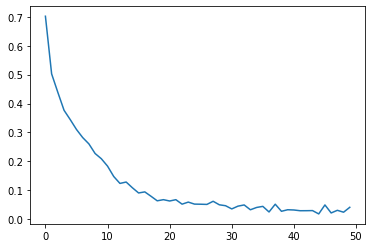

In [61]:
plt.plot(losses)

In [41]:
array = torch.tensor([[1, 2, 3, 4, 5],[5, 4, 3, 2, 1]])

In [44]:
_, tmp = torch.max(array, 1)

In [45]:
tmp

tensor([4, 0])

In [16]:
correct = 0
total = 0
predicted = []
with torch.no_grad():
    model.eval()
    for data in testloader:
        images = data.to(device)
        outputs = model(images)
        mo

tensor([[[[ 0.1523,  0.1802,  0.3730,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.0376,  0.0500,  0.2318,  ...,  2.2489,  2.2489,  2.2489],
          [-0.0331,  0.0143,  0.1772,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 0.3026,  0.3275,  0.5108,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.1854,  0.1944,  0.3664,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.1132,  0.1578,  0.3106,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 0.4364,  0.4723,  0.6958,  ...,  2.6400,  2.6400,  2.6400],
          [ 0.3197,  0.3398,  

tensor([[[[-1.8754, -1.6442, -1.0126,  ...,  0.6090,  0.6269,  0.5132],
          [-1.9950, -1.7807, -1.3940,  ...,  0.6965,  0.7171,  0.6083],
          [-2.0806, -2.0402, -1.9303,  ...,  0.8621,  0.9348,  0.8552],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ..., -0.2755, -0.3934, -0.1354],
          [ 2.2489,  2.2489,  2.2489,  ..., -0.2666, -0.3165, -0.0827],
          [ 2.2489,  2.2489,  2.2489,  ..., -0.0386, -0.1100, -0.2015]],

         [[-1.8054, -1.5689, -0.9232,  ...,  0.6821,  0.7004,  0.5841],
          [-1.9275, -1.7085, -1.3132,  ...,  0.7715,  0.7926,  0.6814],
          [-2.0151, -1.9738, -1.8614,  ...,  0.9407,  1.0151,  0.9338],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ..., -0.2222, -0.3427, -0.0790],
          [ 2.4286,  2.4286,  2.4286,  ..., -0.2131, -0.2641, -0.0251],
          [ 2.4286,  2.4286,  2.4286,  ...,  0.0200, -0.0530, -0.1466]],

         [[-1.6100, -1.3746, -0.7317,  ...,  0.8490,  0.8672,  0.7514],
          [-1.7247, -1.5136, -

tensor([[[[ 0.1940,  0.1988,  0.2245,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.1988,  0.2184,  0.2441,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.2184,  0.2380,  0.2615,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-1.7048, -1.6945, -1.6721,  ..., -1.3974, -1.3339, -1.3159],
          [-1.8970, -1.8699, -1.8413,  ..., -1.2325, -1.2151, -1.2252],
          [-2.0669, -1.9655, -1.9258,  ..., -1.0297, -1.0542, -1.0917]],

         [[ 0.8530,  0.8579,  0.8842,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.8579,  0.8780,  0.9042,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.8780,  0.8980,  0.9220,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-1.6309, -1.6204, -1.5975,  ..., -0.5314, -0.4664, -0.3993],
          [-1.8274, -1.7997, -1.7704,  ..., -0.2427, -0.2249, -0.2248],
          [-2.0173, -1.9137, -1.8731,  ...,  0.0522,  0.0271, -0.0112]],

         [[ 1.7338,  1.7387,  1.7648,  ...,  2.6400,  2.6400,  2.6400],
          [ 1.7387,  1.7586,  

tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  6.0354e-01,
            7.4490e-01,  4.3997e-01],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  1.4728e-01,
            3.9760e-01,  5.8432e-01],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ..., -2.1819e-01,
           -3.8468e-02,  3.4090e-01],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  7.7242e-01,
            6.6897e-01,  5.1205e-01],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  5.7322e-01,
            6.0467e-01,  5.7225e-01],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  4.6252e-01,
            5.2350e-01,  5.8449e-01]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  8.1900e-01,
            8.0515e-01,  4.2446e-01],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  3.5122e-01,
            4.8842e-01,  5.7551e-01],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ..., -3.1342e-02,
            3.6365e-02,  3.2622e-01],
          ...,
     

tensor([[[[ 0.7121,  0.1046, -0.9536,  ..., -1.5120, -1.5303, -1.5812],
          [ 0.6554,  0.0472, -0.8663,  ..., -1.5943, -1.5850, -1.5753],
          [ 0.3855,  0.1413, -0.3752,  ..., -1.7239, -1.7435, -1.7130],
          ...,
          [-0.5326, -0.7595, -1.1774,  ..., -1.6773, -1.7363, -1.8443],
          [-0.8725, -1.0154, -1.1297,  ..., -1.8561, -1.8807, -1.9608],
          [-1.1548, -1.0916, -0.8874,  ..., -1.9438, -1.9403, -1.9635]],

         [[ 0.0435, -0.4822, -1.4189,  ..., -1.5163, -1.5088, -1.5118],
          [ 0.0615, -0.4646, -1.2916,  ..., -1.6005, -1.5618, -1.5473],
          [-0.0584, -0.2513, -0.6953,  ..., -1.7289, -1.7117, -1.6743],
          ...,
          [-0.9727, -1.1147, -1.4064,  ..., -1.5565, -1.6168, -1.7273],
          [-1.2002, -1.2579, -1.2420,  ..., -1.7330, -1.7582, -1.8401],
          [-1.3548, -1.2329, -0.9031,  ..., -1.8227, -1.8191, -1.8429]],

         [[-0.9347, -1.0902, -1.5544,  ..., -1.3695, -1.3359, -1.3501],
          [-0.9301, -1.0938, -

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  0.1597,  0.1597,  0.1597],
          [ 2.2489,  2.2489,  2.2489,  ...,  0.1634,  0.1634,  0.1634],
          [ 2.2489,  2.2489,  2.2489,  ...,  0.1829,  0.1829,  0.1829],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  1.5125,  1.5125,  1.5125],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.5125,  1.5125,  1.5125],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.5125,  1.5125,  1.5125]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  0.7479,  0.7479,  0.7479],
          [ 2.4286,  2.4286,  2.4286,  ...,  0.7517,  0.7517,  0.7517],
          [ 2.4286,  2.4286,  2.4286,  ...,  0.7717,  0.7717,  0.7717],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  1.6933,  1.6933,  1.6933],
          [ 2.4286,  2.4286,  2.4286,  ...,  1.6933,  1.6933,  1.6933],
          [ 2.4286,  2.4286,  2.4286,  ...,  1.6933,  1.6933,  1.6933]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  1.3677,  1.3677,  1.3677],
          [ 2.6400,  2.6400,  

tensor([[[[ 1.9235,  1.9235,  1.9174,  ..., -1.5687, -0.9713, -0.7035],
          [ 1.9235,  1.9228,  1.9151,  ..., -1.3984, -0.8896, -0.4983],
          [ 1.9174,  1.9151,  1.9064,  ..., -1.0520, -0.7151, -0.3258],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  1.7413,  1.7413,  1.7413],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.7217,  1.7217,  1.7217],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.7339,  1.7339,  1.7339]],

         [[ 1.8859,  1.8859,  1.8796,  ..., -1.6493, -1.0386, -0.7648],
          [ 1.8859,  1.8851,  1.8772,  ..., -1.4752, -0.9551, -0.5550],
          [ 1.8796,  1.8772,  1.8683,  ..., -1.1211, -0.7766, -0.3787],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  1.7170,  1.7170,  1.7170],
          [ 2.4286,  2.4286,  2.4286,  ...,  1.6970,  1.6970,  1.6970],
          [ 2.4286,  2.4286,  2.4286,  ...,  1.7095,  1.7095,  1.7095]],

         [[ 2.2740,  2.2740,  2.2678,  ..., -1.4546, -0.8466, -0.5741],
          [ 2.2740,  2.2732,  

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-1.5617, -1.0575, -0.5590,  ...,  2.2489,  2.2489,  2.2489],
          [-1.5129, -0.9497, -0.3832,  ...,  2.2489,  2.2489,  2.2489],
          [-1.3315, -1.0158, -0.6807,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-1.0932, -0.5750, -0.0556,  ...,  2.4286,  2.4286,  2.4286],
          [-1.1045, -0.5258,  0.0641,  ...,  2.4286,  2.4286,  2.4286],
          [-0.9666, -0.6402, -0.2839,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,  

tensor([[[[-0.1301, -0.1256, -0.1070,  ..., -0.1486, -0.1486, -0.1486],
          [-0.1023, -0.0891, -0.0814,  ..., -0.1486, -0.1486, -0.1486],
          [-0.0446, -0.0422, -0.0336,  ..., -0.1424, -0.1424, -0.1424],
          ...,
          [-0.8375, -0.8771, -0.8935,  ...,  2.2489,  2.2489,  2.2489],
          [-0.7867, -0.9507, -1.0487,  ...,  2.2489,  2.2489,  2.2489],
          [-0.7318, -0.9668, -1.1487,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 0.8193,  0.8239,  0.8429,  ...,  0.7654,  0.7654,  0.7654],
          [ 0.8477,  0.8612,  0.8691,  ...,  0.7654,  0.7654,  0.7654],
          [ 0.9067,  0.9091,  0.9180,  ...,  0.7717,  0.7717,  0.7717],
          ...,
          [-0.4453, -0.4859, -0.5026,  ...,  2.4286,  2.4286,  2.4286],
          [-0.4260, -0.5936, -0.6938,  ...,  2.4286,  2.4286,  2.4286],
          [-0.3736, -0.6138, -0.7998,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 1.8371,  1.8348,  1.8283,  ...,  1.6988,  1.6988,  1.6988],
          [ 1.8330,  1.8465,  

tensor([[[[-1.5676, -1.4202, -1.4088,  ...,  2.2489,  2.2489,  2.2489],
          [-1.6172, -1.4487, -1.1563,  ...,  2.2489,  2.2489,  2.2489],
          [-1.5072, -1.3572, -0.8676,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 0.8545,  0.8521,  0.8435,  ...,  1.4269,  1.4183,  1.4159],
          [ 0.9058,  0.9022,  0.8839,  ...,  1.4183,  1.4106,  1.4098],
          [ 0.9291,  0.9254,  0.9058,  ...,  1.4159,  1.4098,  1.4098]],

         [[-1.4731, -1.3225, -1.3108,  ...,  2.4286,  2.4286,  2.4286],
          [-1.5238, -1.3516, -1.0526,  ...,  2.4286,  2.4286,  2.4286],
          [-1.4114, -1.2580, -0.7575,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 1.0030,  1.0006,  0.9917,  ...,  1.5882,  1.5794,  1.5770],
          [ 1.0555,  1.0518,  1.0331,  ...,  1.5794,  1.5715,  1.5707],
          [ 1.0793,  1.0755,  1.0555,  ...,  1.5770,  1.5707,  1.5707]],

         [[-1.2443, -1.0944, -1.0827,  ...,  2.6400,  2.6400,  2.6400],
          [-1.2948, -1.1234, -

tensor([[[[ 2.0583,  2.0909,  1.9978,  ..., -0.3920, -0.3724, -0.3528],
          [ 1.9808,  2.0563,  2.0400,  ..., -0.3505, -0.3267, -0.3063],
          [ 2.0209,  2.0715,  2.1114,  ..., -0.2987, -0.2574, -0.2342],
          ...,
          [ 0.2351,  0.2281,  0.2272,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.2514,  0.2543,  0.2710,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.3590,  0.3740,  0.3754,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.3212,  2.3546,  2.2656,  ...,  0.6741,  0.6941,  0.7141],
          [ 2.2345,  2.3117,  2.3013,  ...,  0.7165,  0.7408,  0.7617],
          [ 2.2297,  2.2872,  2.3320,  ...,  0.7694,  0.8117,  0.8354],
          ...,
          [ 0.3698,  0.3627,  0.3618,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.3865,  0.3895,  0.4065,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.4965,  0.5118,  0.5133,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.6342,  2.6253,  2.5226,  ...,  2.1134,  2.1333,  2.1532],
          [ 2.5551,  2.6245,  

tensor([[[[-0.8481, -0.7894, -1.3375,  ..., -1.7326, -1.6015, -1.7377],
          [-0.5232, -0.8847, -1.3194,  ..., -1.7606, -1.5648, -1.6224],
          [-0.3463, -0.6805, -0.7479,  ..., -1.8432, -1.5788, -1.4901],
          ...,
          [ 0.7619,  0.5541,  0.6623,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.0234,  0.9910,  0.8436,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.2172,  1.1001,  0.8662,  ...,  2.2489,  2.2489,  2.2489]],

         [[-0.6875, -0.6713, -1.2792,  ..., -1.7201, -1.5213, -1.6472],
          [-0.3554, -0.7687, -1.2607,  ..., -1.7619, -1.5128, -1.5386],
          [-0.1745, -0.5599, -0.6764,  ..., -1.8727, -1.5557, -1.4427],
          ...,
          [ 0.8096,  0.6033,  0.7366,  ...,  2.4286,  2.4286,  2.4286],
          [ 1.0706,  1.0451,  0.9219,  ...,  2.4286,  2.4286,  2.4286],
          [ 1.2688,  1.1565,  0.9449,  ...,  2.4286,  2.4286,  2.4286]],

         [[-0.7573, -0.7213, -1.3127,  ..., -1.6409, -1.4903, -1.6268],
          [-0.4266, -0.8182, -

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,  

tensor([[[[-3.5737e-01, -3.2024e-01, -1.6647e-01,  ..., -2.6843e-01,
           -2.6843e-01, -2.6843e-01],
          [-5.6174e-01, -1.9119e-01,  2.0503e-01,  ..., -2.7577e-01,
           -2.7577e-01, -2.7577e-01],
          [-3.0679e-01, -1.5988e-03,  4.3290e-01,  ..., -3.0880e-01,
           -3.0880e-01, -3.0880e-01],
          ...,
          [ 1.2275e+00,  1.2262e+00,  1.2214e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 1.1945e+00,  1.1974e+00,  1.2080e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 1.1565e+00,  1.1715e+00,  1.1782e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.0286e-01,  2.3528e-01,  3.6775e-01,  ...,  5.5532e-01,
            5.5532e-01,  5.5532e-01],
          [ 8.1390e-03,  3.5926e-01,  7.5317e-01,  ...,  5.4782e-01,
            5.4782e-01,  5.4782e-01],
          [ 2.6396e-01,  5.5800e-01,  9.6843e-01,  ...,  5.1406e-01,
            5.1406e-01,  5.1406e-01],
          ...,
     

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-1.3052, -1.2453, -1.1386,  ..., -1.6915, -1.5929, -1.5532],
          [-1.2687, -1.2564, -1.2041,  ..., -1.7092, -1.5716, -1.5308],
          [-1.2287, -1.1964, -1.1080,  ..., -1.6522, -1.4852, -1.4550]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-1.1173, -1.0674, -1.0121,  ..., -1.4485, -1.3414, -1.3009],
          [-1.0801, -1.0758, -1.0652,  ..., -1.4754, -1.3226, -1.2779],
          [-1.0241, -1.0136, -0.9632,  ..., -1.4196, -1.2351, -1.2005]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,  

tensor([[[[-1.6898, -1.6898, -1.6898,  ..., -1.6384, -1.6384, -1.6384],
          [-1.6898, -1.6898, -1.6898,  ..., -1.6384, -1.6384, -1.6384],
          [-1.6898, -1.6898, -1.6898,  ..., -1.6384, -1.6384, -1.6384],
          ...,
          [-1.2507, -1.2507, -1.2507,  ...,  2.2489,  2.2489,  2.2489],
          [-1.2445, -1.2445, -1.2445,  ...,  2.2489,  2.2489,  2.2489],
          [-1.2445, -1.2445, -1.2445,  ...,  2.2489,  2.2489,  2.2489]],

         [[-0.8452, -0.8452, -0.8452,  ..., -0.7227, -0.7227, -0.7227],
          [-0.8452, -0.8452, -0.8452,  ..., -0.7227, -0.7227, -0.7227],
          [-0.8452, -0.8452, -0.8452,  ..., -0.7227, -0.7227, -0.7227],
          ...,
          [-0.0812, -0.0812, -0.0812,  ...,  2.4286,  2.4286,  2.4286],
          [-0.0749, -0.0749, -0.0749,  ...,  2.4286,  2.4286,  2.4286],
          [-0.0749, -0.0749, -0.0749,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 0.3045,  0.3045,  0.3045,  ...,  0.4439,  0.4439,  0.4439],
          [ 0.3045,  0.3045,  

tensor([[[[ 1.6850,  1.6848,  1.6781,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.7046,  1.7009,  1.6875,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.7180,  1.7157,  1.7070,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 1.8521,  1.8518,  1.8450,  ...,  2.4286,  2.4286,  2.4286],
          [ 1.8721,  1.8683,  1.8546,  ...,  2.4286,  2.4286,  2.4286],
          [ 1.8859,  1.8834,  1.8746,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.0661,  2.0658,  2.0591,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.0860,  2.0823,  

tensor([[[[-1.6384, -1.6384, -1.6384,  ...,  2.2489,  2.2489,  2.2489],
          [-1.6384, -1.6384, -1.6384,  ...,  2.2489,  2.2489,  2.2489],
          [-1.6384, -1.6384, -1.6384,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-1.6727, -1.6727, -1.6727,  ...,  2.2489,  2.2489,  2.2489],
          [-1.6727, -1.6727, -1.6727,  ...,  2.2489,  2.2489,  2.2489],
          [-1.6727, -1.6727, -1.6727,  ...,  2.2489,  2.2489,  2.2489]],

         [[-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
          [-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
          [-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-2.0182, -2.0182, -2.0182,  ...,  2.4286,  2.4286,  2.4286],
          [-2.0182, -2.0182, -2.0182,  ...,  2.4286,  2.4286,  2.4286],
          [-2.0182, -2.0182, -2.0182,  ...,  2.4286,  2.4286,  2.4286]],

         [[-1.4036, -1.4036, -1.4036,  ...,  2.6400,  2.6400,  2.6400],
          [-1.4036, -1.4036, -

tensor([[[[ 1.7020e+00,  1.6336e+00,  1.5537e+00,  ..., -1.6392e+00,
           -1.6521e+00, -1.6555e+00],
          [ 1.7780e+00,  1.6785e+00,  1.5858e+00,  ..., -1.6507e+00,
           -1.6555e+00, -1.6555e+00],
          [ 1.8261e+00,  1.7292e+00,  1.6202e+00,  ..., -1.6555e+00,
           -1.6555e+00, -1.6555e+00],
          ...,
          [-1.2077e+00, -1.0668e+00, -9.6163e-01,  ..., -1.3439e+00,
           -1.5557e+00, -1.5918e+00],
          [-1.3739e+00, -1.1928e+00, -1.0524e+00,  ..., -1.4846e+00,
           -1.5807e+00, -1.6957e+00],
          [-1.3799e+00, -1.2980e+00, -1.2624e+00,  ..., -1.6173e+00,
           -1.5579e+00, -1.6813e+00]],

         [[ 1.8181e+00,  1.7518e+00,  1.6828e+00,  ..., -3.0252e-01,
           -3.0252e-01, -3.0252e-01],
          [ 1.9196e+00,  1.8180e+00,  1.7219e+00,  ..., -3.0252e-01,
           -3.0252e-01, -3.0252e-01],
          [ 2.0151e+00,  1.9147e+00,  1.7943e+00,  ..., -3.0252e-01,
           -3.0252e-01, -3.0252e-01],
          ...,
     

tensor([[[[-0.1063, -0.3639, -0.6321,  ..., -0.7643, -0.8512, -0.8287],
          [-0.2492, -0.3222, -0.4322,  ..., -0.7028, -0.7565, -0.7090],
          [-0.4649, -0.3966, -0.3597,  ..., -0.5907, -0.6439, -0.5909],
          ...,
          [-0.9142, -0.9196, -0.9511,  ..., -0.2342, -0.2342, -0.2342],
          [-0.9465, -1.0183, -1.1039,  ..., -0.2207, -0.2207, -0.2207],
          [-0.9594, -1.0562, -1.1361,  ..., -0.2171, -0.2171, -0.2171]],

         [[-0.0667, -0.3301, -0.5917,  ..., -0.8269, -0.9158, -0.8928],
          [-0.2128, -0.2874, -0.3874,  ..., -0.7641, -0.8190, -0.7705],
          [-0.4334, -0.3635, -0.3133,  ..., -0.6494, -0.7038, -0.6497],
          ...,
          [-0.9627, -0.9634, -0.9779,  ..., -0.2850, -0.2850, -0.2850],
          [-0.9938, -1.0400, -1.1216,  ..., -0.2713, -0.2713, -0.2713],
          [-0.9763, -1.0728, -1.1546,  ..., -0.2675, -0.2675, -0.2675]],

         [[ 0.0512, -0.2110, -0.4777,  ..., -0.6359, -0.7244, -0.7015],
          [-0.0942, -0.1685, -

tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ..., -4.3968e-01,
           -4.3968e-01, -4.3968e-01],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ..., -4.3601e-01,
           -4.3601e-01, -4.3601e-01],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ..., -4.2255e-01,
           -4.2255e-01, -4.2255e-01],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  1.8768e-01,
            1.8768e-01,  1.8768e-01],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  1.8017e-01,
            1.8017e-01,  1.8017e-01],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  1.5266e-01,
            1.5266e-01,  1.5266e-01],
          ...,
     

tensor([[[[ 0.1925, -0.0144, -0.1084,  ..., -1.3807, -0.9128, -0.5181],
          [ 0.4184,  0.1072, -0.2256,  ..., -1.4700, -1.0753, -0.6852],
          [ 1.0191,  0.5356, -0.1076,  ..., -1.0975, -0.8747, -0.6717],
          ...,
          [-1.9407, -1.7515, -1.6096,  ..., -1.3491, -1.1870, -0.8609],
          [-1.5055, -1.6105, -1.5682,  ..., -1.1466, -1.0558, -0.9982],
          [-1.1383, -1.4889, -1.4177,  ..., -0.9380, -1.1452, -1.1231]],

         [[ 0.2250,  0.0772,  0.0424,  ..., -0.9907, -0.5514, -0.1400],
          [ 0.4666,  0.2037, -0.0785,  ..., -1.1071, -0.7226, -0.3364],
          [ 1.1200,  0.6521,  0.0463,  ..., -0.7752, -0.5422, -0.3739],
          ...,
          [-1.7412, -1.5021, -1.3387,  ..., -1.0047, -0.8536, -0.5243],
          [-1.2706, -1.3390, -1.2688,  ..., -0.7976, -0.7048, -0.6459],
          [-0.8615, -1.2139, -1.1086,  ..., -0.5844, -0.7962, -0.7736]],

         [[ 0.1686,  0.0414,  0.0267,  ..., -0.7354, -0.3249,  0.0378],
          [ 0.4132,  0.1747, -

tensor([[[[-0.3315, -0.0088,  0.4671,  ..., -1.3764, -1.9301, -2.0047],
          [ 0.0279,  0.1702,  0.5006,  ..., -1.1190, -1.7397, -1.9976],
          [ 0.3594,  0.3537,  0.5216,  ..., -0.8083, -1.4561, -1.9069],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[-0.5246, -0.1944,  0.2801,  ..., -0.8087, -1.4729, -1.6021],
          [-0.1534, -0.0050,  0.3249,  ..., -0.5432, -1.2548, -1.5929],
          [ 0.1993,  0.1934,  0.3485,  ..., -0.2189, -0.9727, -1.4895],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[-0.7183, -0.3901,  0.0750,  ..., -0.0219, -0.8032, -1.0169],
          [-0.3562, -0.2144,  

tensor([[[[ 1.5125,  1.5125,  1.5187,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.5125,  1.5125,  1.5173,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.5064,  1.5077,  1.5125,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ..., -2.0775, -2.0775, -2.0775],
          [ 2.2489,  2.2489,  2.2489,  ..., -2.0971, -2.0971, -2.0971],
          [ 2.2489,  2.2489,  2.2489,  ..., -2.1008, -2.1008, -2.1008]],

         [[ 1.6758,  1.6758,  1.6820,  ...,  2.4286,  2.4286,  2.4286],
          [ 1.6758,  1.6758,  1.6807,  ...,  2.4286,  2.4286,  2.4286],
          [ 1.6695,  1.6709,  1.6758,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ..., -1.9944, -1.9944, -1.9944],
          [ 2.4286,  2.4286,  2.4286,  ..., -2.0145, -2.0145, -2.0145],
          [ 2.4286,  2.4286,  2.4286,  ..., -2.0182, -2.0182, -2.0182]],

         [[ 1.8905,  1.8905,  1.8968,  ...,  2.6400,  2.6400,  2.6400],
          [ 1.8905,  1.8905,  